In [ ]:
# Plot ROC curve with various thresholds for single experiment

import json

K = 10
n = 1000
label_frequency = 0.5
train_pi = 0.2
test_pi = 0.8
exp_number = 2

file_path = f"output/GaussTest/{n}/0.5/{train_pi}/{test_pi}/nnPUcc/{label_frequency}/{exp_number}/metrics.json"

with open(file_path, "r") as f:
    metrics_contents = json.load(f)

model = 'drpu'
pi_estimates = metrics_contents['test_pis']
roc_data = metrics_contents['TC'][model]['roc_curve']
fpr = roc_data['fpr']
tpr = roc_data['tpr']
thresholds = roc_data['thresholds']
thresholds = [float(threshold) for threshold in thresholds]

# roc curve
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# threshold = 0.5
idx_05 = np.argmin(np.abs([threshold - 0.5 for threshold in thresholds]))
plt.scatter(fpr[idx_05], tpr[idx_05], color='orange', label='Threshold = 0.5', s=80, zorder=5, marker='*')

# optimal threshold 
optimal_threshold = train_pi * (1 - test_pi) / ((1 - train_pi) * test_pi + train_pi * (1 - test_pi))
idx_optimal = np.argmin(np.abs([threshold - optimal_threshold for threshold in thresholds]))
plt.scatter(fpr[idx_optimal], tpr[idx_optimal], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}', s=80, zorder=5, marker='^')

# heuristic thresholds - Youden’s J Statistic
J = [tpr[i] - fpr[i] for i in range(len(fpr))]
idx_youden = np.argmax(J)
youden_threshold = thresholds[idx_youden]
plt.scatter(fpr[idx_youden], tpr[idx_youden], color='blue', label=f'Youden’s J Statistic = {youden_threshold:.2f}', s=80, zorder=5, marker='^')

for pi_method in ["DR", "KM1", "KM2"]:
    pi = metrics_contents['test_pis'][pi_method]
    corrected_threshold = train_pi * (1 - pi) / ((1 - train_pi) * pi + train_pi * (1 - pi))
    idx_corr = np.argmin(np.abs([threshold - corrected_threshold for threshold in thresholds]))
    plt.scatter(fpr[idx_corr], tpr[idx_corr], color='green', label=f"{pi_method} Threshold = {corrected_threshold:.2f} ($\hat\pi'={pi:.2}$)", s=80, zorder=5, marker='x', linewidths=2)
    plt.annotate(f'{pi_method}', 
                 (fpr[idx_corr], tpr[idx_corr]), 
                 textcoords="offset points", 
                 xytext=(0, 10), 
                 ha='center', 
                 fontsize=10, 
                 color='green')

plt.title(f"ROC Curve for {model} ($\pi={train_pi}, \pi'={test_pi}$)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Experiment to test MLLS EM estimation of test priors using Ringnorm dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchhd.datasets import Ringnorm
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Parameters
train_size_per_class = 500
test_size = 1000
input_dim = 20
hidden_dim = 10
num_epochs = 100
learning_rate = 0.01
test_priors = [0.1 * i for i in range(1, 10)]  # [0.1, 0.2, ..., 0.9]
n_repeats = 10
max_em_iter = 5
tol = 1e-3

# Define simple MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return torch.sigmoid(self.fc2(x)).view(-1)

# MLLS EM estimation
def run_em(probs, train_pi, max_iter=20, tol=1e-3):
    new_pi = train_pi
    for i in range(max_iter):
        nom = (new_pi / train_pi) * probs
        denom = nom + ((1 - new_pi) / (1 - train_pi)) * (1 - probs)
        adjusted_post = nom / denom
        updated_pi = adjusted_post.mean().item()
        if abs(updated_pi - new_pi) < tol:
            break
        new_pi = updated_pi
    print(f"EM converged in {i+1} iterations, estimated π': {new_pi}")
    return new_pi

# Storage
results = {p: [] for p in test_priors}

# Main experiment
for _ in range(n_repeats):
    # Prepare training data with balanced priors (0.5 / 0.5)
    full_data = Ringnorm(root='./data', train=True, download=True)
    x_train = []
    y_train = []
    x_test, y_test = [], []
    pos_count, neg_count = 0, 0
    for x, y in full_data:
        if y == 1:
            if pos_count < train_size_per_class:
                x_train.append(x)
                y_train.append(1)
                pos_count += 1
            else:
                x_test.append(x)
                y_test.append(1)
        elif y == 0:
            if neg_count < train_size_per_class:
                x_train.append(x)
                y_train.append(0)
                neg_count += 1
            else:
                x_test.append(x)
                y_test.append(0)


    x_train = torch.stack(x_train)
    y_train = torch.tensor(y_train)

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)

    # Train model
    model = MLP(input_dim=input_dim, hidden_dim=hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = F.binary_cross_entropy(pred, yb.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Run test sets for various priors
    full_test_data = list(zip(x_test, y_test))
    for pi_test in test_priors:
        print(f'\nTest prior π\'={pi_test}')
        n_pos = int(test_size * pi_test)
        n_neg = test_size - n_pos
        print(f'Sampling {n_pos} positive and {n_neg} negative instances.')
        pos_samples = [x for x, y in full_test_data if y == 1][:n_pos]
        neg_samples = [x for x, y in full_test_data if y == 0][:n_neg]
        x_test_sel = torch.stack(pos_samples + neg_samples)
        print(f'selected test set size: {x_test_sel.shape[0]}')
        print(f'selected data: {x_test_sel}')
        # y_test_sel = torch.tensor([1]*n_pos + [0]*n_neg)

        with torch.no_grad():
            probs = model(x_test_sel).cpu()
            print(probs)

        estimated_pi = run_em(probs, train_pi=0.5, max_iter=max_em_iter, tol=tol)
        print(estimated_pi)
        results[pi_test].append(estimated_pi)

import pandas as pd

# Summarize results
summary = {
    "True π'": [],
    "Estimated π' (mean)": [],
    "Estimated π' (std)": [],
}

for pi_test, estimates in results.items():
    summary["True π'"].append(round(pi_test, 2))
    summary["Estimated π' (mean)"].append(round(np.mean(estimates), 4))
    summary["Estimated π' (std)"].append(round(np.std(estimates), 4))

df_results = pd.DataFrame(summary)
df_results


## Experiment 1 - Synthethic (Gauss)

In [ ]:
# gauss - test
from PULS.models import LabelShiftConfig
from PULS.dataset import Gauss_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

K = 10
n = 1000
label_frequency = 0.5

for train_pi in [0.2, 0.4, 0.6, 0.8]:
    for test_pi in [0.2, 0.4, 0.6, 0.8]:
        for exp_number in range(0, K):

            label_shift_config = LabelShiftConfig(train_prior=train_pi, train_n_samples=n, test_prior=test_pi, test_n_samples=n)

            dataset_config = DatasetConfig(
                f"GaussTest/{label_shift_config.train_n_samples or 'all'}/0.5/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
                DatasetClass=Gauss_PULS,
                PULabelerClass=SCAR_CC_Labeler,
            )
            
            gauss_experiment_config = ExperimentConfig(
                PULoss=nnPUccLoss,
                dataset_config=dataset_config,
                label_frequency=label_frequency,
                exp_number=exp_number,
            )

            experiment = PULSExperiment(experiment_config=gauss_experiment_config, label_shift_config=label_shift_config)
            experiment.run()
            experiment.train_ratio_estimator()
            experiment.test_shifted()

            print(experiment.metrics)
            print(experiment.test_pis)

In [ ]:
# gauss
from PULS.models import LabelShiftConfig
from PULS.dataset import Gauss_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

K = 10
n = 1000
LABEL_FREQUENCIES = [0.25, 0.5, 0.75]
PI_GRID = [0.2, 0.4, 0.6, 0.8]

for label_frequency in LABEL_FREQUENCIES:
    for train_pi in PI_GRID:
        for test_pi in PI_GRID:
            for exp_number in range(0, K):

                label_shift_config = LabelShiftConfig(train_prior=train_pi, train_n_samples=n, test_prior=test_pi, test_n_samples=n)

                dataset_config = DatasetConfig(
                    f"Gauss/{label_shift_config.train_n_samples or 'all'}/0.5/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
                    DatasetClass=Gauss_PULS,
                    PULabelerClass=SCAR_CC_Labeler,
                )
                
                gauss_experiment_config = ExperimentConfig(
                    PULoss=nnPUccLoss,
                    dataset_config=dataset_config,
                    label_frequency=label_frequency,
                    exp_number=exp_number,
                )

                experiment = PULSExperiment(experiment_config=gauss_experiment_config, label_shift_config=label_shift_config)
                experiment.run()
                experiment.train_ratio_estimator()
                experiment.test_shifted()

                print(experiment.metrics)
                print(experiment.test_pis)

## Experiment 2 - MNIST

In [ ]:
# mnist
# train data
# 60000 observations (30000 positive, prior - 0.5)
# test data
# 10000 observations (5000 positive, prior - 0.5)

from PULS.models import LabelShiftConfig
from PULS.dataset import MNIST_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequency = 0.1
pi_grid = [0.2, 0.4, 0.6, 0.8]

for test_pi in pi_grid:
    label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=50_000, test_prior=test_pi, test_n_samples=5_000)

    # label_frequency = 0.5
    # label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=5_00, test_prior=0.5, test_n_samples=5_00)

    dataset_config = DatasetConfig(
        f"MNIST/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
        DatasetClass=MNIST_PULS,
        PULabelerClass=SCAR_CC_Labeler,
    )
    mnist_experiment_config = ExperimentConfig(
        PULoss=nnPUccLoss,
        dataset_config=dataset_config,
        label_frequency=label_frequency,
        exp_number=exp_number,
        force_cpu=True,
    )

    experiment = PULSExperiment(experiment_config=mnist_experiment_config, label_shift_config=label_shift_config)
    experiment.run()
    experiment.train_ratio_estimator()
    experiment.test_shifted()

    print(experiment.metrics)
    print(experiment.test_pis)

### all data

In [ ]:
# mnist
# train data
# 60000 observations (30000 positive, prior - 0.5)
# test data
# 10000 observations (5000 positive, prior - 0.5)

from PULS.models import LabelShiftConfig
from PULS.dataset import MNIST_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequencies = [0.1, 0.25, 0.5, 0.75, 0.9]

for label_frequency in label_frequencies:
    label_shift_config = LabelShiftConfig()

    dataset_config = DatasetConfig(
        f"MNIST/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
        DatasetClass=MNIST_PULS,
        PULabelerClass=SCAR_CC_Labeler,
    )
    mnist_experiment_config = ExperimentConfig(
        PULoss=nnPUccLoss,
        dataset_config=dataset_config,
        label_frequency=label_frequency,
        exp_number=exp_number,
        force_cpu=True,
    )

    experiment = PULSExperiment(experiment_config=mnist_experiment_config, label_shift_config=label_shift_config)
    experiment.run()
    experiment.train_ratio_estimator()
    experiment.test_shifted()

    print(experiment.metrics)
    print(experiment.test_pis)

## Experiment 3 - FashionMNIST

In [ ]:
# fashion mnist
# train data
# 60000 observations (30000 positive, prior - 0.5)
# test data
# 10000 observations (5000 positive, prior - 0.5)

from PULS.models import LabelShiftConfig
from PULS.dataset import FashionMNIST_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequency = 0.1
pi_grid = [0.2, 0.4, 0.6, 0.8]

for test_pi in pi_grid:
    label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=50_000, test_prior=test_pi, test_n_samples=5_000)

    dataset_config = DatasetConfig(
        f"FashionMNIST/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
        DatasetClass=FashionMNIST_PULS,
        PULabelerClass=SCAR_CC_Labeler,
    )
    fashion_mnist_experiment_config = ExperimentConfig(
        PULoss=nnPUccLoss,
        dataset_config=dataset_config,
        label_frequency=label_frequency,
        exp_number=exp_number,
        force_cpu=True,
    )

    experiment = PULSExperiment(experiment_config=fashion_mnist_experiment_config, label_shift_config=label_shift_config)
    experiment.run()
    experiment.train_ratio_estimator()
    experiment.test_shifted()

    print(experiment.metrics)
    print(experiment.test_pis)

### all data

In [ ]:
# fashion mnist
# train data
# 60000 observations (30000 positive, prior - 0.5)
# test data
# 10000 observations (5000 positive, prior - 0.5)

from PULS.models import LabelShiftConfig
from PULS.dataset import FashionMNIST_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequencies = [0.1, 0.25, 0.5, 0.75, 0.9]

for label_frequency in label_frequencies:
    label_shift_config = LabelShiftConfig()

    dataset_config = DatasetConfig(
        f"FashionMNIST/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
        DatasetClass=FashionMNIST_PULS,
        PULabelerClass=SCAR_CC_Labeler,
    )
    fashion_mnist_experiment_config = ExperimentConfig(
        PULoss=nnPUccLoss,
        dataset_config=dataset_config,
        label_frequency=label_frequency,
        exp_number=exp_number,
        force_cpu=True,
    )

    experiment = PULSExperiment(experiment_config=fashion_mnist_experiment_config, label_shift_config=label_shift_config)
    experiment.run()
    experiment.train_ratio_estimator()
    experiment.test_shifted()

    print(experiment.metrics)
    print(experiment.test_pis)

## Experiment 4 - ChestXRay

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train set prior: 0.5
Epoch: 1/50
6/6 [========] - 0s 82ms/step - loss: 0.4831 - acc: 0.5536 - test_loss: 0.4957 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
2/6 [=>......] - ETA: 0s - loss: 0.4135 - acc: 0.6787

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [========] - 0s 70ms/step - loss: 0.3864 - acc: 0.7125 - test_loss: 0.4927 - test_accuracy: 81.5000 - pos_fraction: 0.0150
Epoch: 3/50
6/6 [========] - 0s 68ms/step - loss: 0.3203 - acc: 0.7994 - test_loss: 0.4844 - test_accuracy: 88.0000 - pos_fraction: 0.1000
Epoch: 4/50
6/6 [========] - 0s 69ms/step - loss: 0.2651 - acc: 0.8342 - test_loss: 0.4675 - test_accuracy: 90.5000 - pos_fraction: 0.1550
Epoch: 5/50
6/6 [========] - 0s 78ms/step - loss: 0.2240 - acc: 0.8537 - test_loss: 0.4405 - test_accuracy: 90.0000 - pos_fraction: 0.1900
Epoch: 6/50
6/6 [========] - 0s 65ms/step - loss: 0.1893 - acc: 0.8621 - test_loss: 0.4062 - test_accuracy: 90.5000 - pos_fraction: 0.2050
Epoch: 7/50
6/6 [========] - 0s 67ms/step - loss: 0.1591 - acc: 0.8674 - test_loss: 0.3685 - test_accuracy: 90.5000 - pos_fraction: 0.2250
Epoch: 8/50
6/6 [========] - 0s 69ms/step - loss: 0.1315 - acc: 0.8617 - test_loss: 0.3351 - test_accuracy: 91.0000 - pos_fraction: 0.2400
Epoch: 9/50
6/6 [========] - 0s 70ms/st

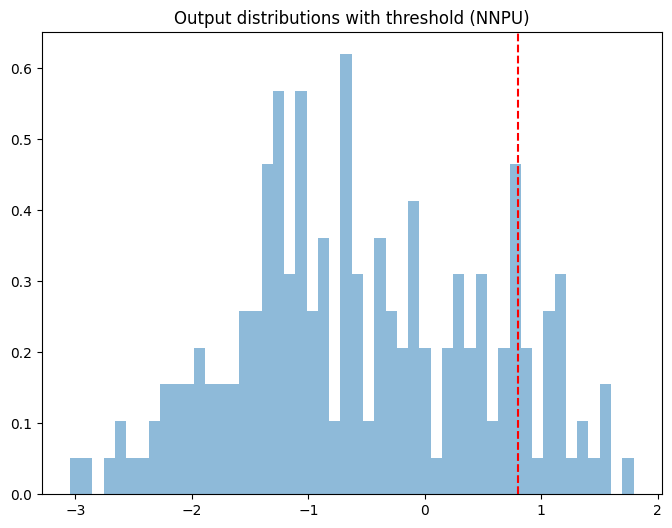

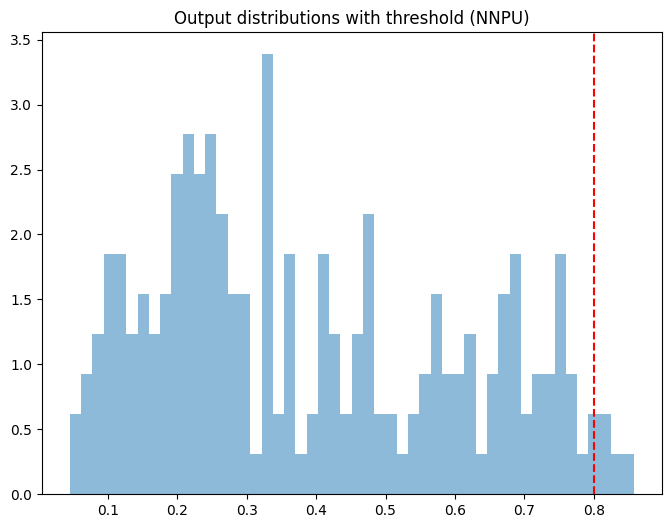

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1509 - accuracy: 80.0000 - pos_fraction: 0.0000e+00

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


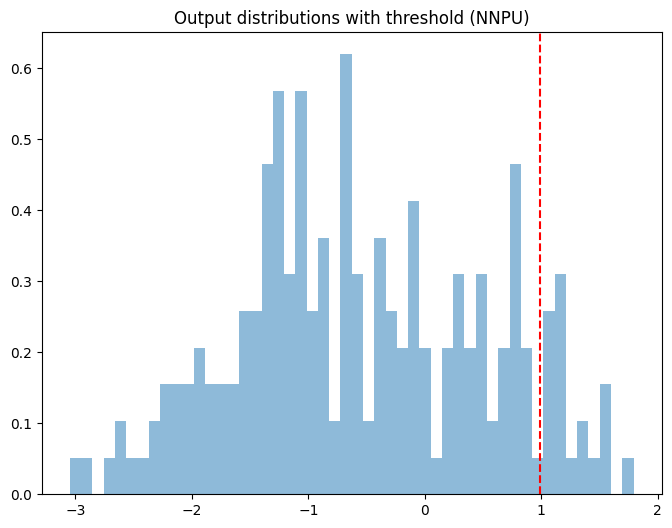

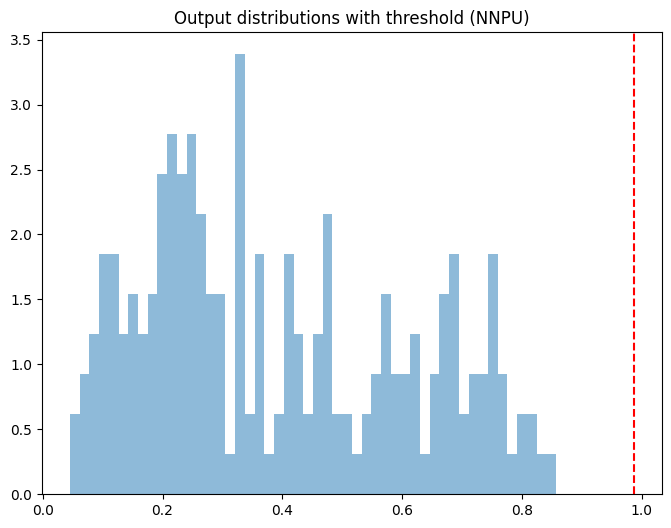

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1509 - accuracy: 83.0000 - pos_fraction: 0.0300

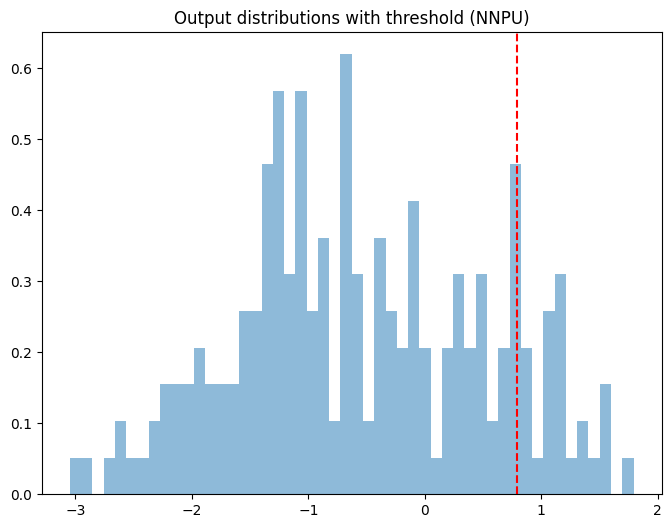

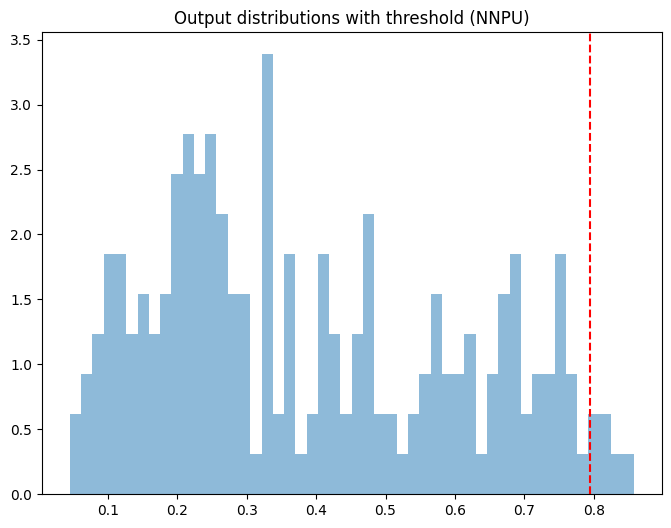

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1509 - accuracy: 80.0000 - pos_fraction: 0.0000e+00

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


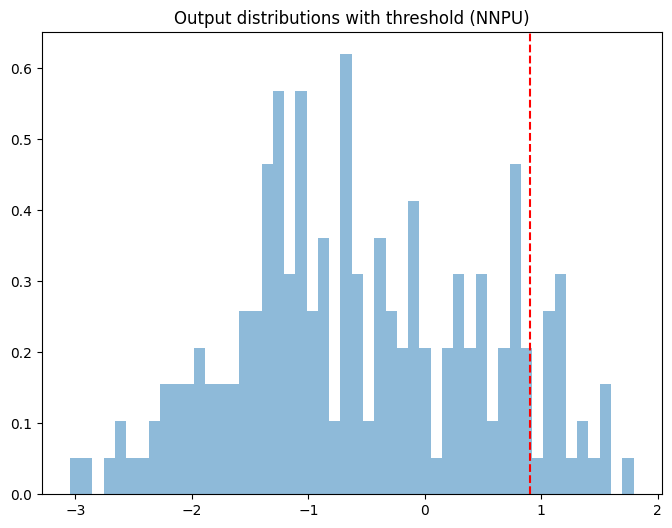

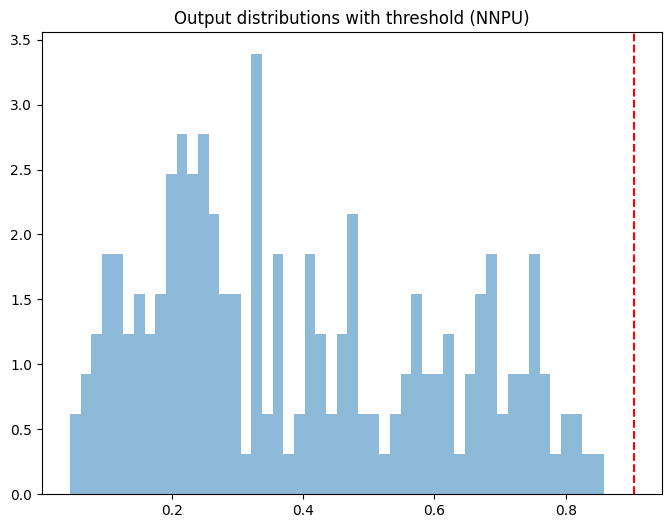

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1509 - accuracy: 80.0000 - pos_fraction: 0.0000e+00

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


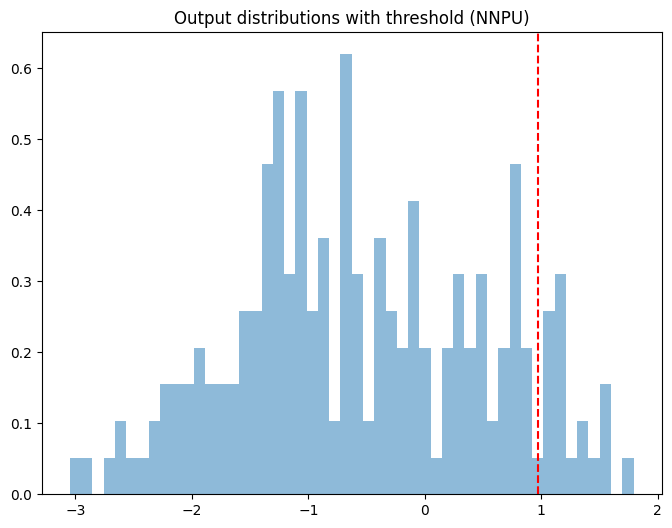

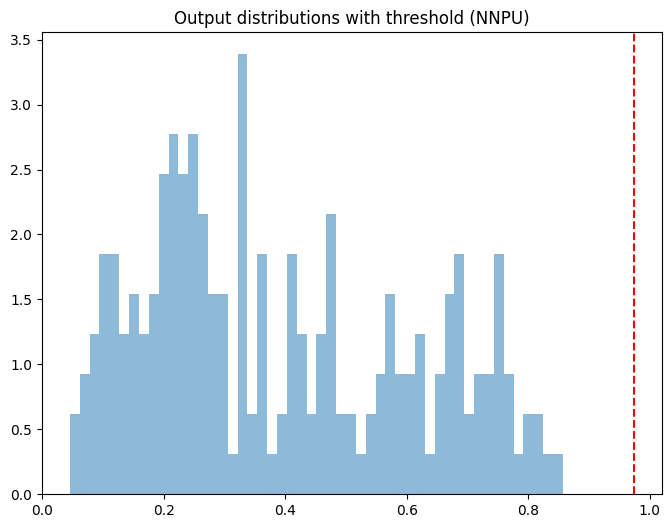

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1509 - accuracy: 20.0000 - pos_fraction: 1.0000

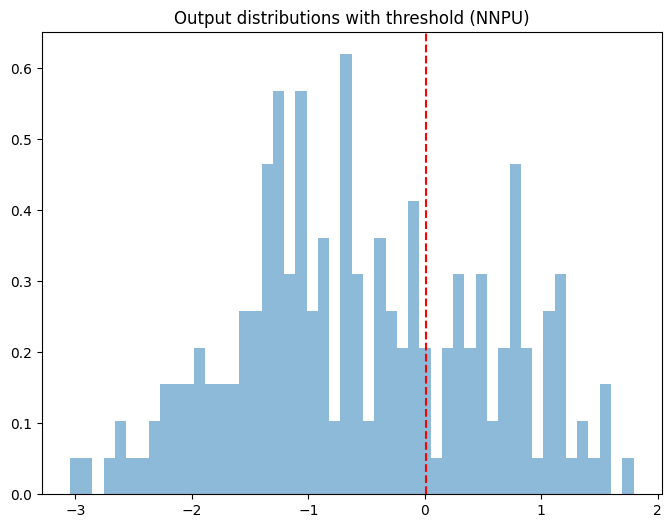

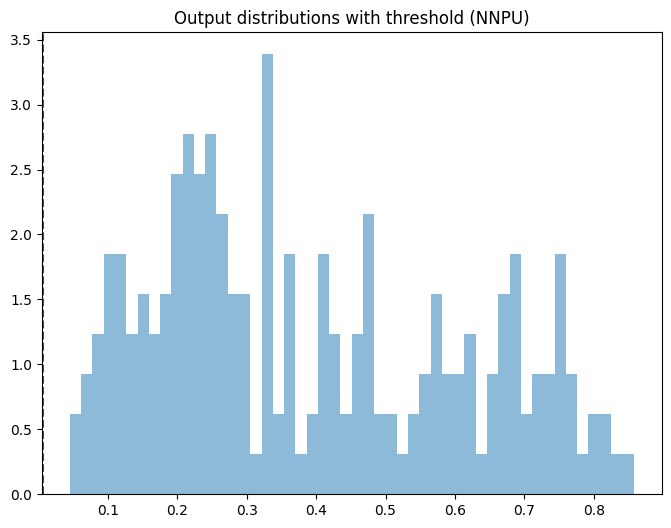

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 94.0000 - pos_fraction: 0.1400drpu y_scores:
[0.3044537  0.5743879  0.41205162 0.8127529  0.9150071  0.7897255
 0.9148346  0.3614985  0.97853255 0.9048881  0.         0.9116571
 0.87757534 0.83689296 0.7220291  0.81889194 0.61188793 0.9050788
 0.92543983 0.8151113  0.53700054 0.         1.0565503  0.24239099
 0.8243327  0.1140693  0.36374536 0.7465159  0.7139298  0.58000404
 0.35668918 0.82643056 0.6407739  0.75237465 0.8856931  0.9525886
 0.7255871  0.39936432 0.40839592 0.3902456  0.         0.09023925
 0.         0.         0.         0.         0.13837619 0

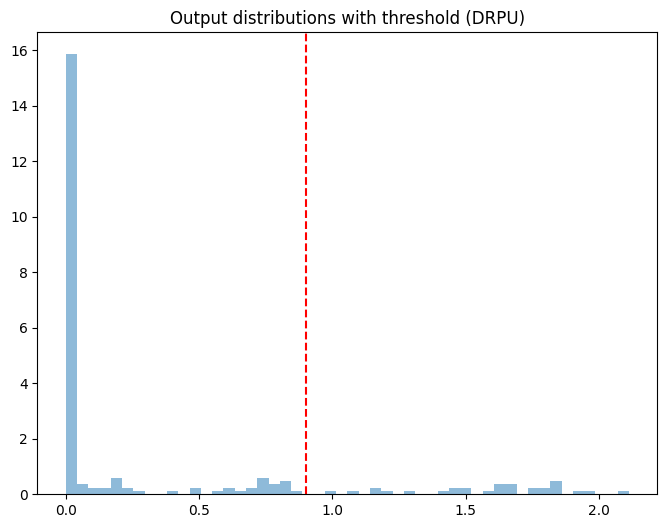

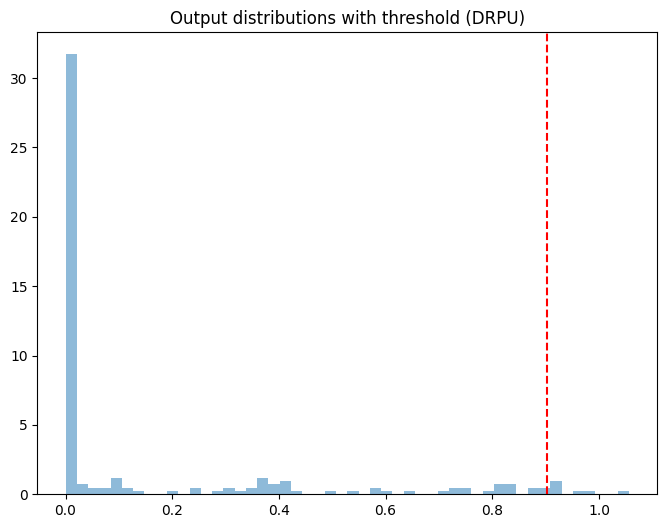

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 80.5000 - pos_fraction: 0.0050

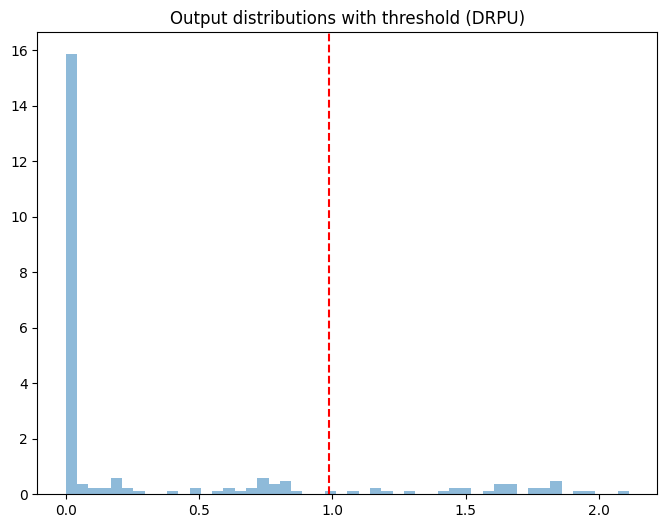

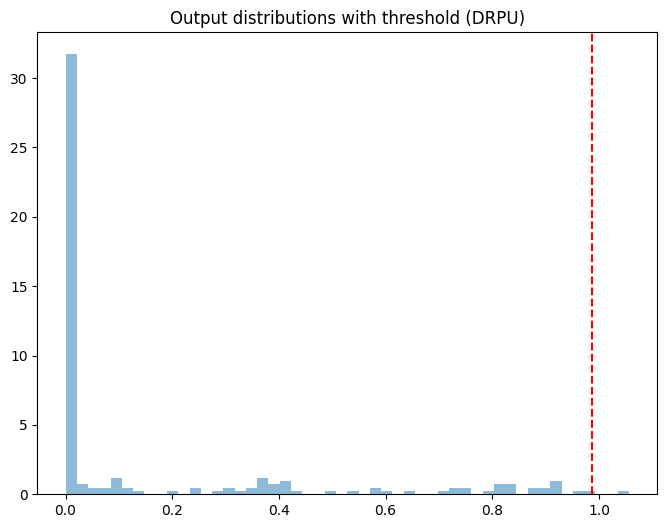

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 88.5000 - pos_fraction: 0.0850

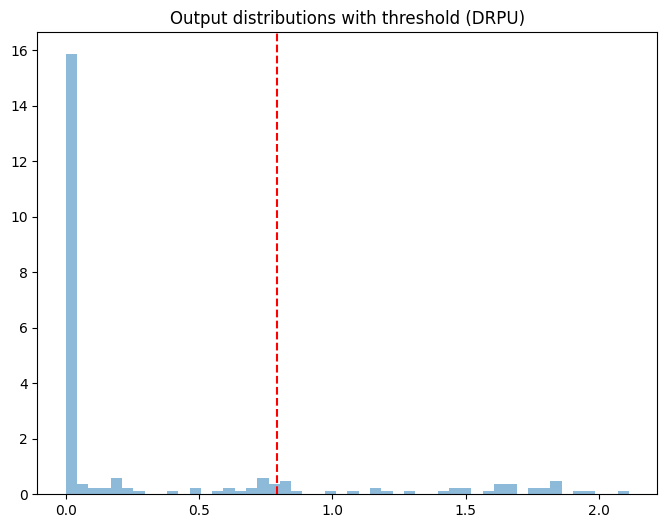

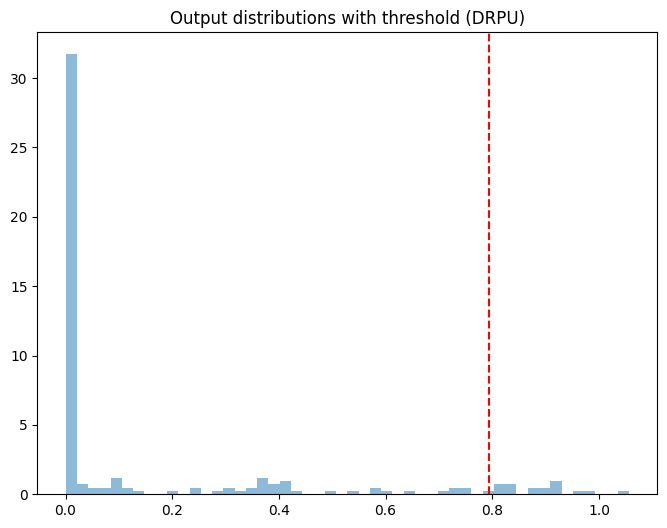

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 84.5000 - pos_fraction: 0.0450

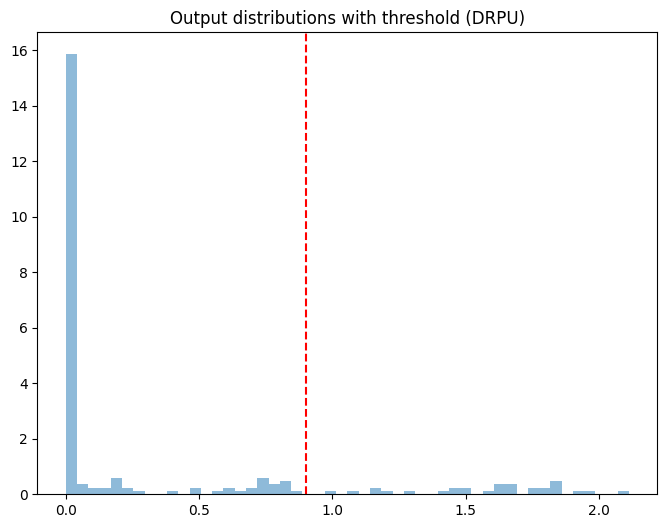

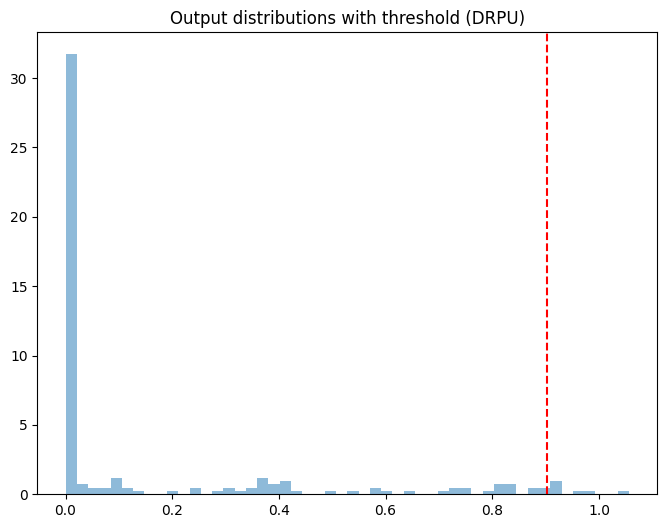

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 81.0000 - pos_fraction: 0.0100

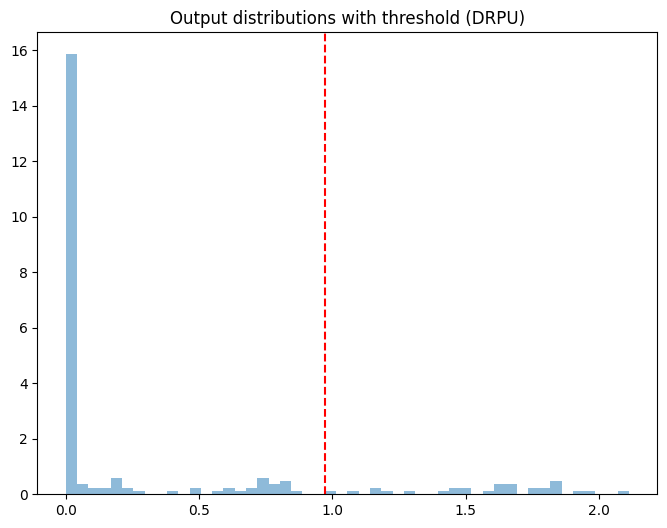

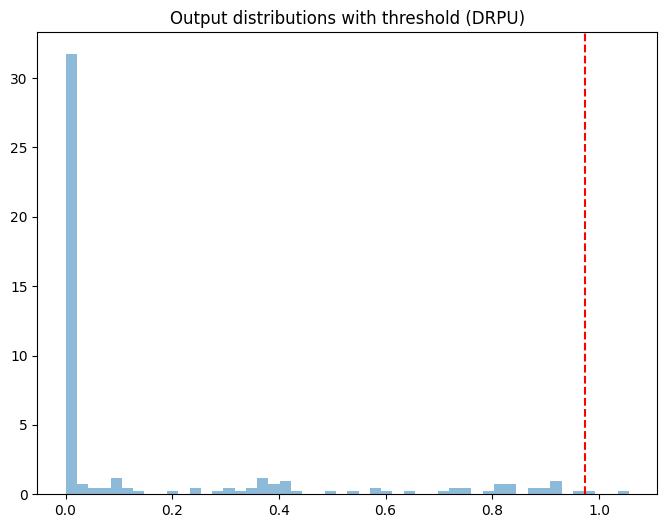

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 85.0000 - pos_fraction: 0.3300

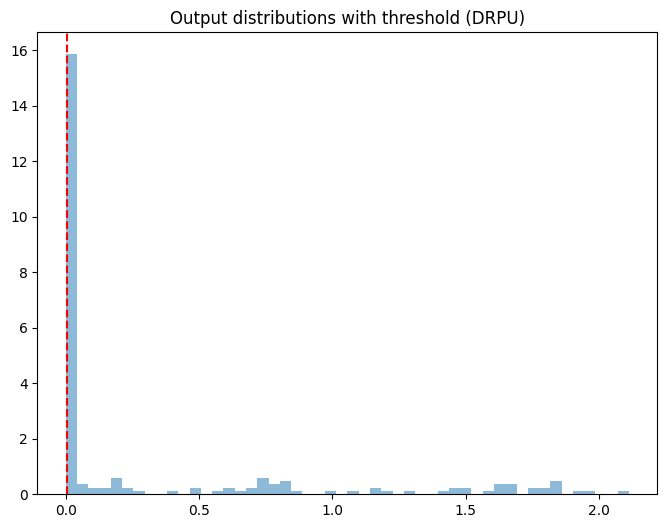

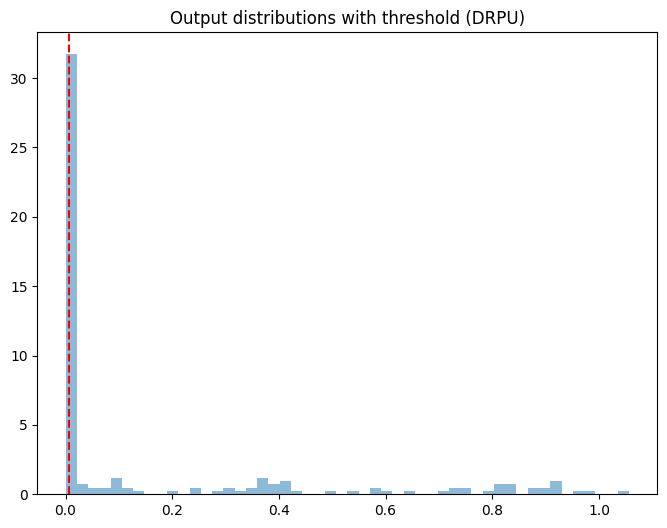

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1509 - accuracy: 88.0000 - pos_fraction: 0.3100

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


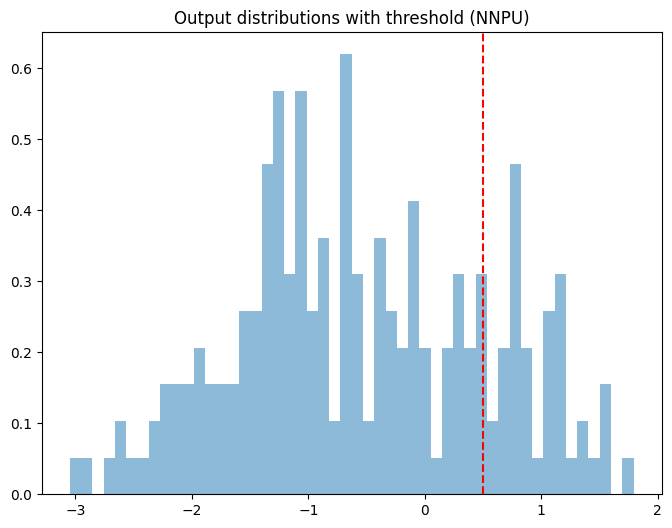

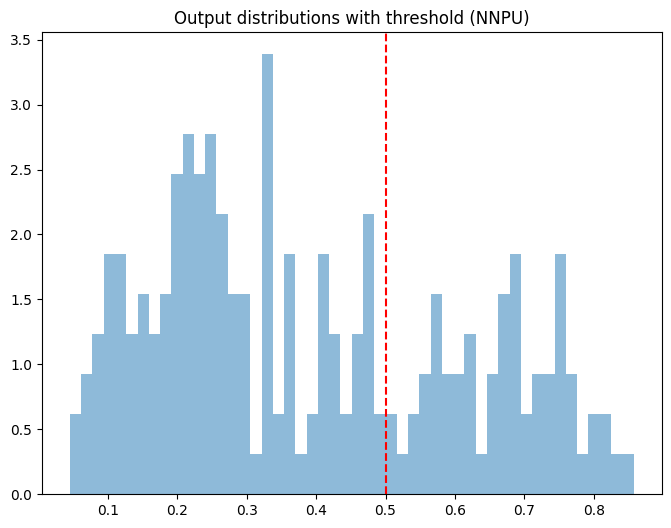

Epoch: 1/1
positive: torch.Size([40]), unlabeled: torch.Size([88]), alpha: 0.5
E_pp: 0.20056240260601044, E_pn: 0.9920626878738403, E_u: 0.02952774614095688, E_n: -0.4665035903453827, loss: 0.4665035903453827
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.017672918736934662, E_n: 0.017672918736934662, loss: -0.48232707381248474
1/3 [=>......] - ETA: 0s - test_loss: -0.0079 - accuracy: 94.0000 - pos_fraction: 0.1400

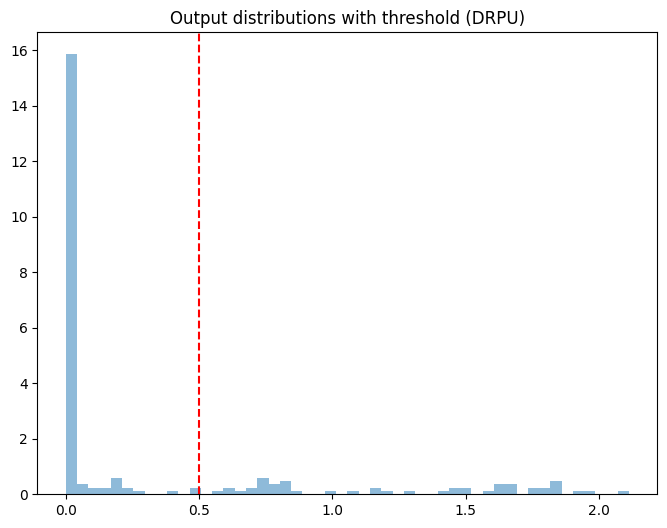

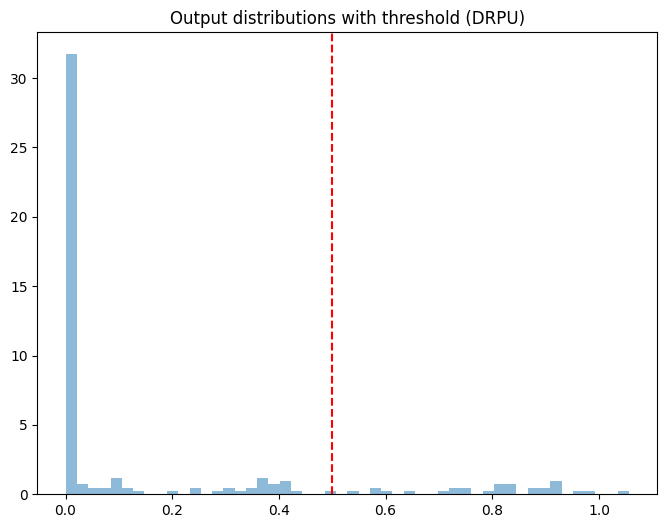

Metrics saved to output\ChestXRay/2475/0.5/0.2\nnPUcc\0.2\0\metrics.json
{'dataset_stats': {'train': {'n_pos': 1100, 'n_neg': 1100, 'n_p': 275, 'n_u': 2200, 'n_samples': 2475}, 'test': {'n_pos': 40, 'n_neg': 160, 'n_p': 0, 'n_u': 200, 'n_samples': 200}}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='ChestXRay/2475/0.5/0.2', label_frequency=0.2, exp_number=0, accuracy=0.88, precision=0.6290322580645161, recall=0.975, f1=0.7647058823529411, auc=0.915625, loss=None, epoch=None, stopping_epoch=None, time=None), 'roc_curve': {'fpr': [0.0, 0.0, 0.0, 0.00625, 0.00625, 0.0125, 0.0125, 0.025, 0.025, 0.03125, 0.03125, 0.0375, 0.0375, 0.09375, 0.09375, 0.125, 0.125, 0.14375, 0.14375, 0.175, 0.175, 1.0], 'tpr': [0.0, 0.025, 0.5, 0.5, 0.55, 0.55, 0.625, 0.625, 0.825, 0.825, 0.85, 0.85, 0.9, 0.9, 0.925, 0.925, 0.95, 0.95, 0.975, 0.975, 1.0, 1.0], 'thresholds': [1.8572309017181396, 0.8572308421134949, 0.7237315773963928, 0.7143721580505371, 0.7099943161010742, 0.6964876651763916, 0.6

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train set prior: 0.5
Epoch: 1/50
6/6 [========] - 0s 75ms/step - loss: 0.4831 - acc: 0.5536 - test_loss: 0.4959 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
2/6 [=>......] - ETA: 0s - loss: 0.4135 - acc: 0.6787

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [========] - 0s 66ms/step - loss: 0.3864 - acc: 0.7125 - test_loss: 0.4933 - test_accuracy: 62.0000 - pos_fraction: 0.0200
Epoch: 3/50
6/6 [========] - 0s 63ms/step - loss: 0.3203 - acc: 0.7994 - test_loss: 0.4859 - test_accuracy: 70.0000 - pos_fraction: 0.1200
Epoch: 4/50
6/6 [========] - 0s 68ms/step - loss: 0.2651 - acc: 0.8342 - test_loss: 0.4707 - test_accuracy: 78.0000 - pos_fraction: 0.2200
Epoch: 5/50
6/6 [========] - 0s 66ms/step - loss: 0.2240 - acc: 0.8537 - test_loss: 0.4460 - test_accuracy: 81.5000 - pos_fraction: 0.2950
Epoch: 6/50
6/6 [========] - 0s 72ms/step - loss: 0.1893 - acc: 0.8621 - test_loss: 0.4151 - test_accuracy: 84.0000 - pos_fraction: 0.3200
Epoch: 7/50
6/6 [========] - 0s 67ms/step - loss: 0.1591 - acc: 0.8674 - test_loss: 0.3821 - test_accuracy: 85.5000 - pos_fraction: 0.3550
Epoch: 8/50
6/6 [========] - 0s 76ms/step - loss: 0.1315 - acc: 0.8617 - test_loss: 0.3516 - test_accuracy: 88.0000 - pos_fraction: 0.3900
Epoch: 9/50
6/6 [========] - 0s 80ms/st

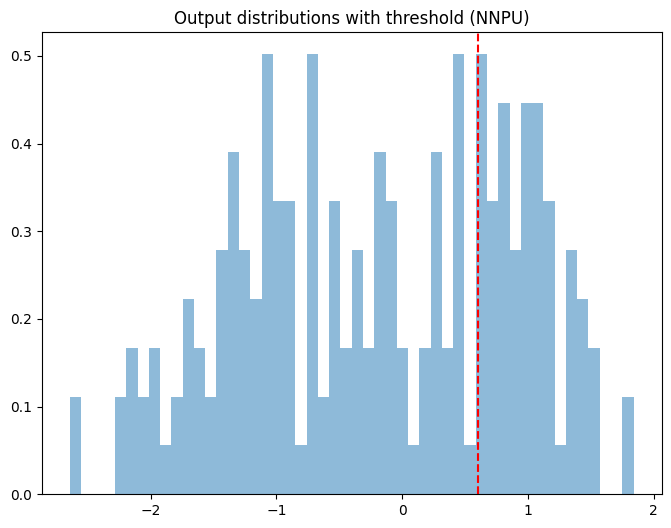

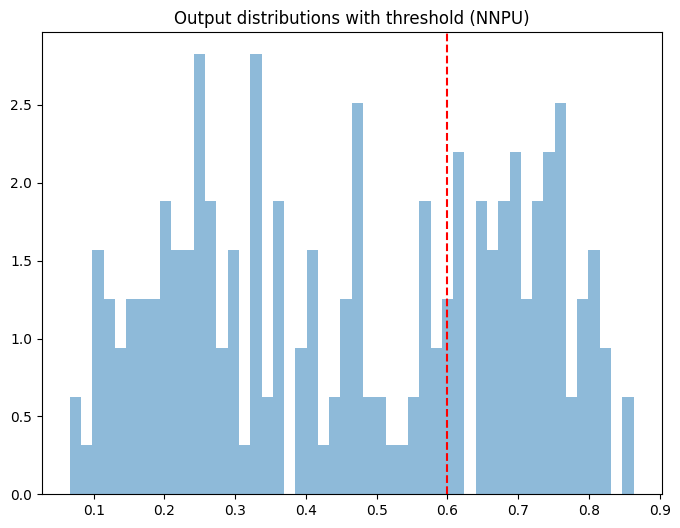

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1667 - accuracy: 60.0000 - pos_fraction: 0.0000e+00

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


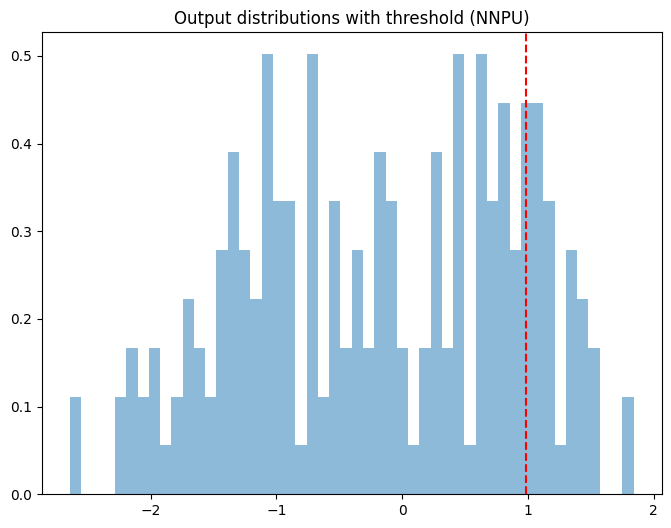

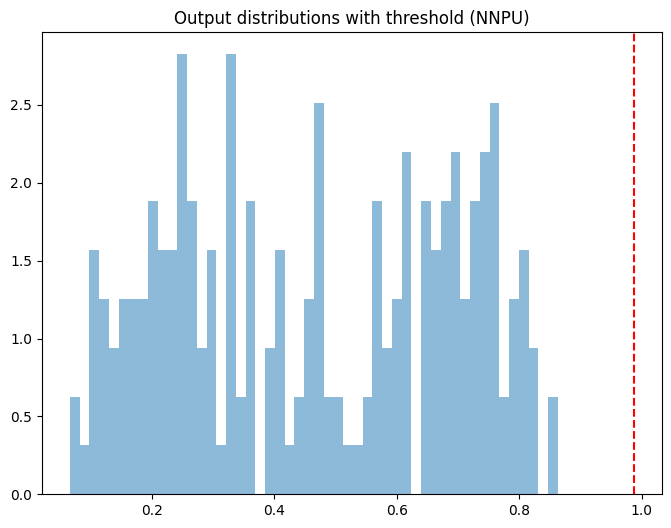

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1667 - accuracy: 76.5000 - pos_fraction: 0.1650

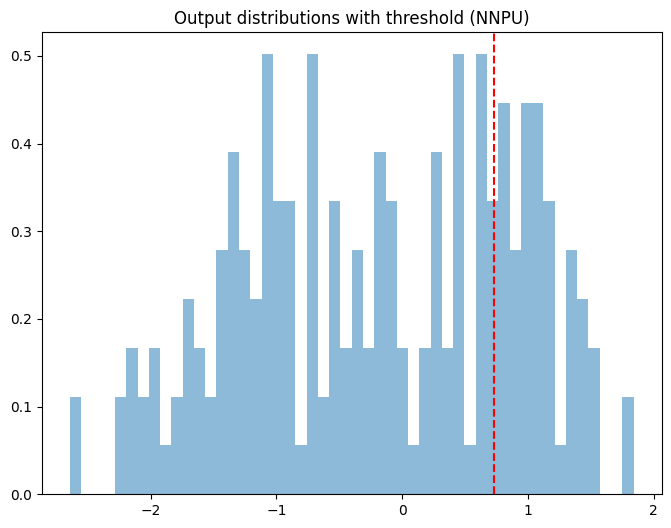

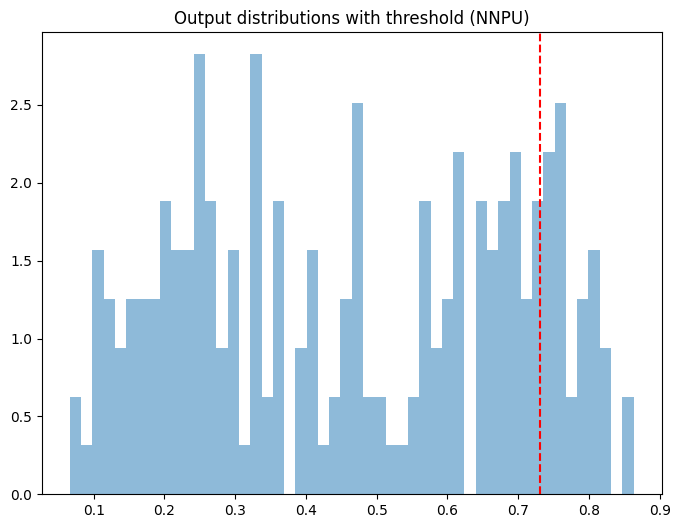

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1667 - accuracy: 61.0000 - pos_fraction: 0.0100

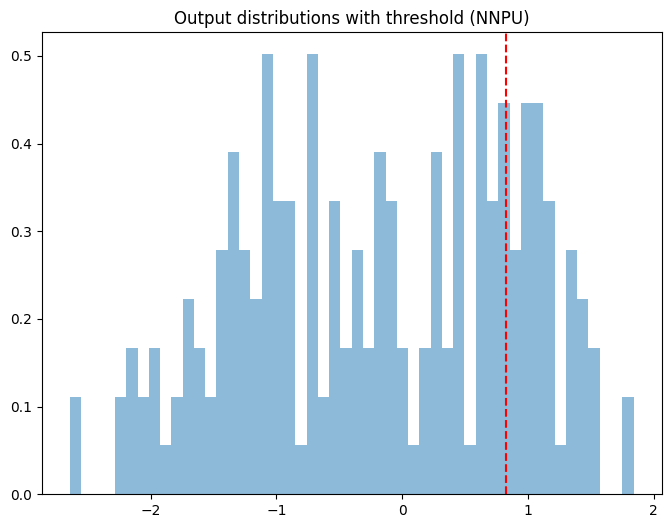

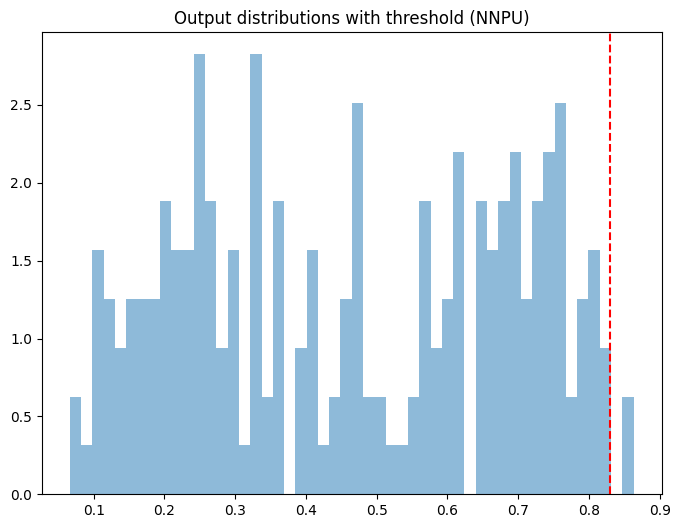

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1667 - accuracy: 84.0000 - pos_fraction: 0.2800

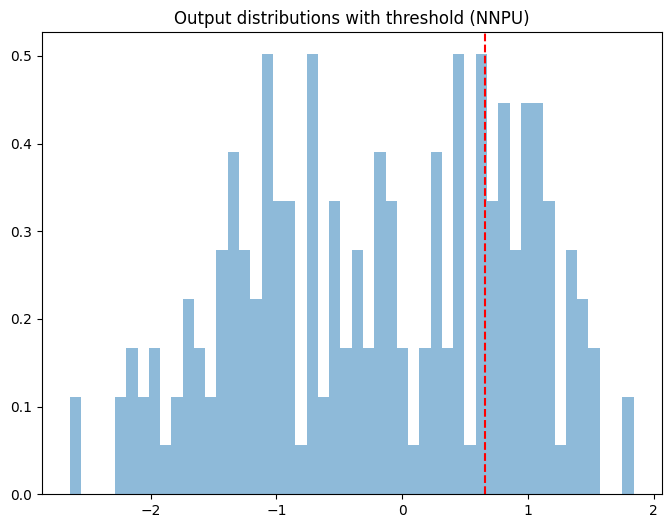

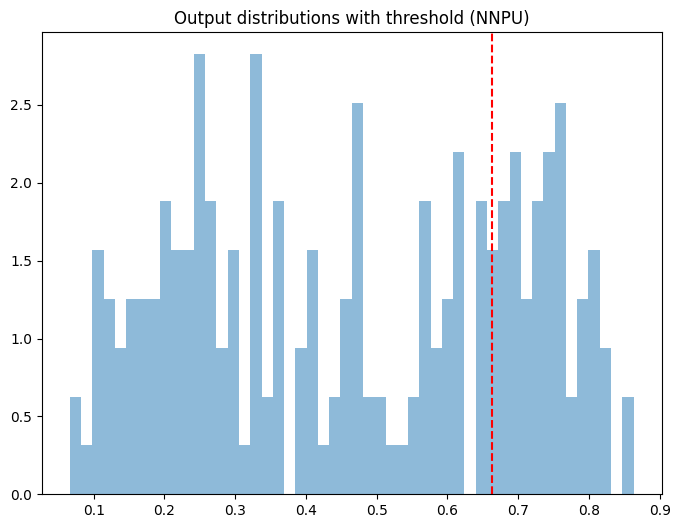

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1667 - accuracy: 40.0000 - pos_fraction: 1.0000

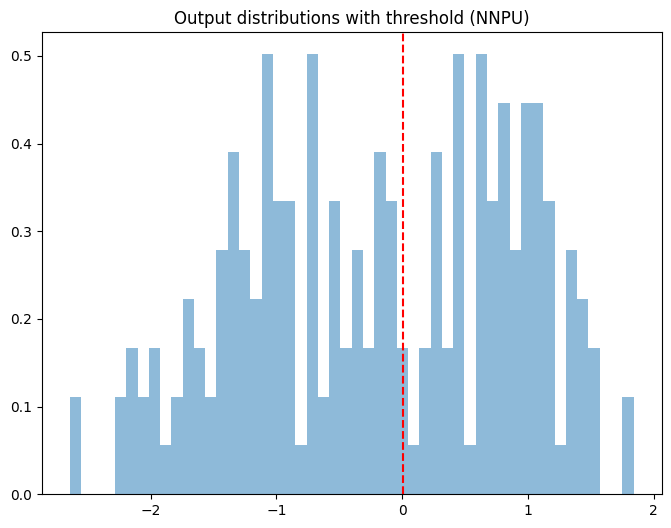

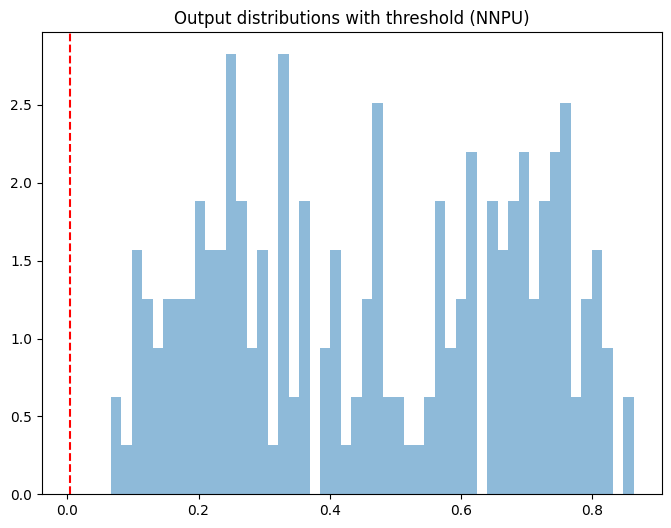

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 86.5000 - pos_fraction: 0.2650drpu y_scores:
[0.3044537  0.5743879  0.41205162 0.8127529  0.9150071  0.7897255
 0.9148346  0.3614985  0.97853255 0.9048881  0.         0.9116571
 0.87757534 0.83689296 0.7220291  0.81889194 0.61188793 0.9050788
 0.92543983 0.8151113  0.53700054 0.         1.0565503  0.24239099
 0.8243327  0.1140693  0.36374536 0.7465159  0.7139298  0.58000404
 0.35668918 0.82643056 0.6407739  0.75237465 0.8856931  0.9525886
 0.7255871  0.39936432 0.40839592 0.3902456  0.         0.89069235
 0.4189497  0.4039621  0.7630092  0.35194245 0.76330507

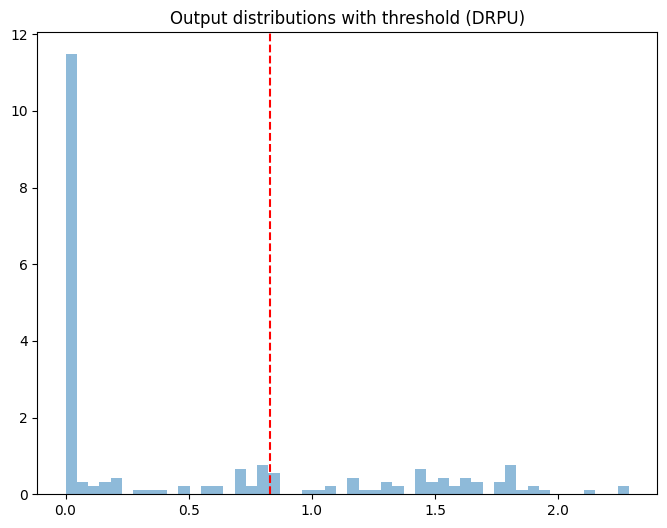

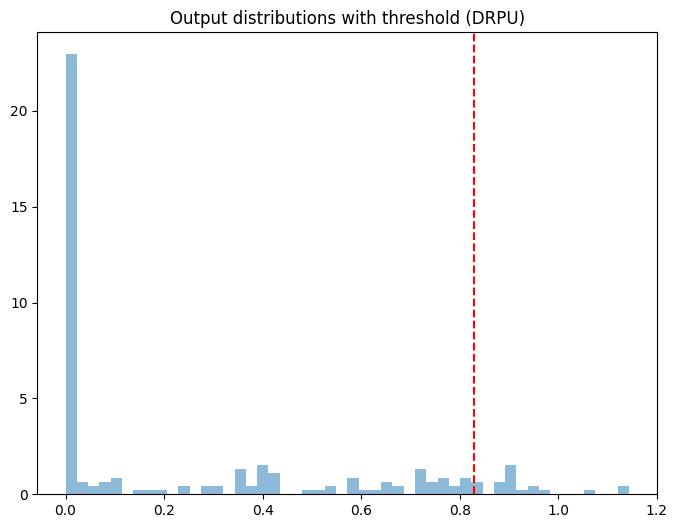

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 61.5000 - pos_fraction: 0.0150

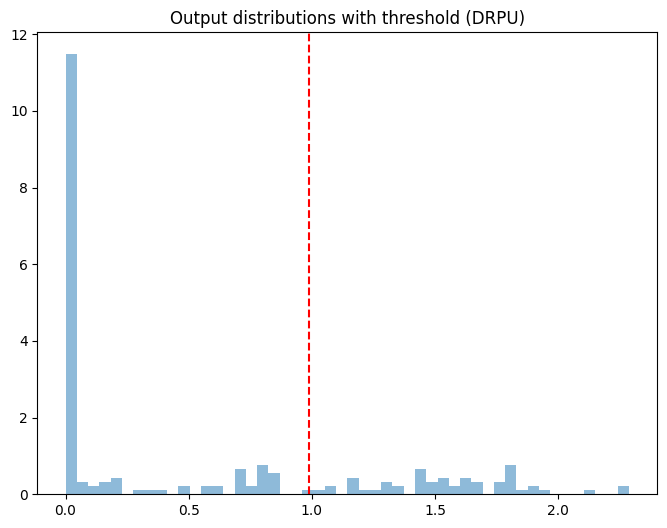

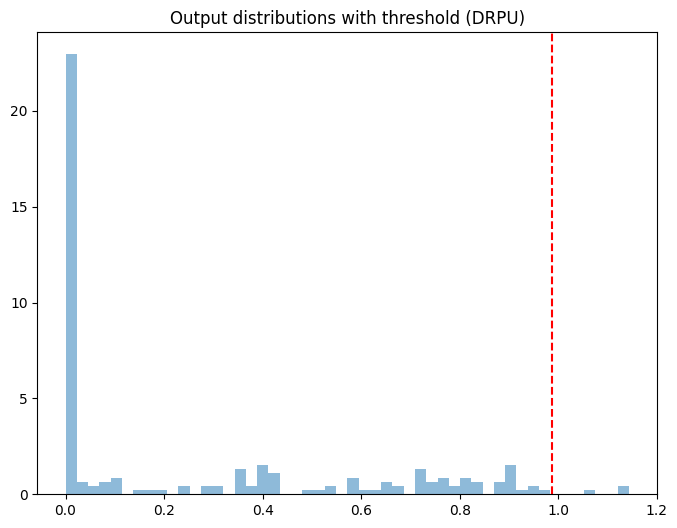

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 77.0000 - pos_fraction: 0.1700

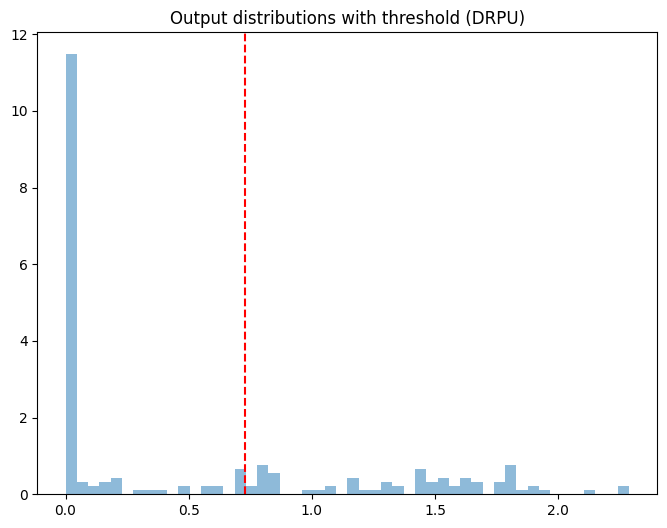

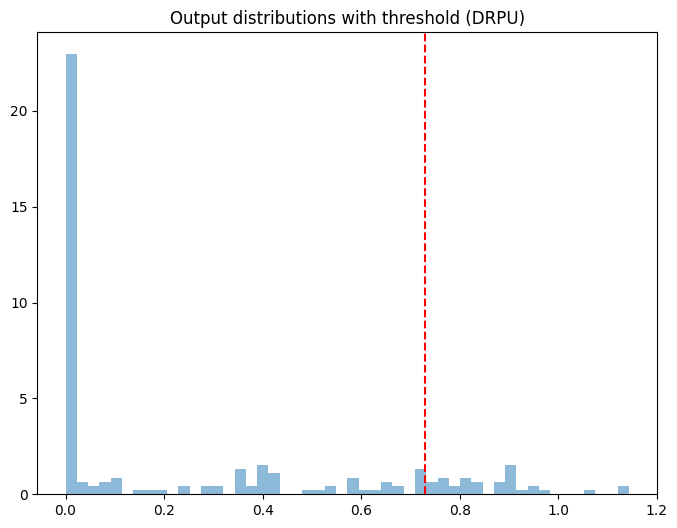

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 69.0000 - pos_fraction: 0.0900

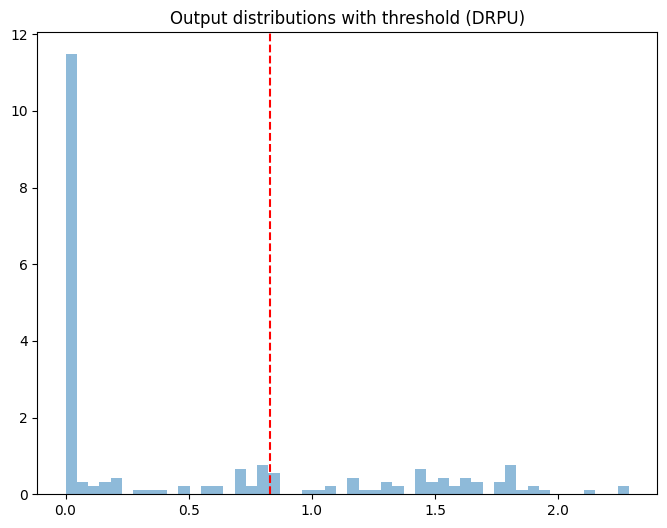

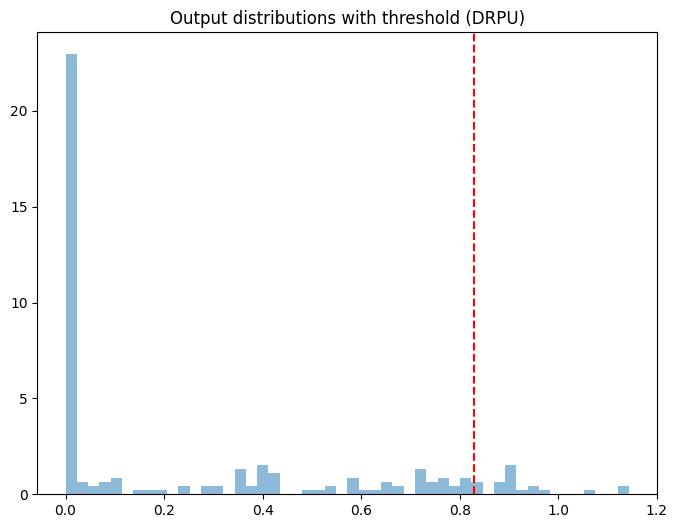

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 80.5000 - pos_fraction: 0.2050

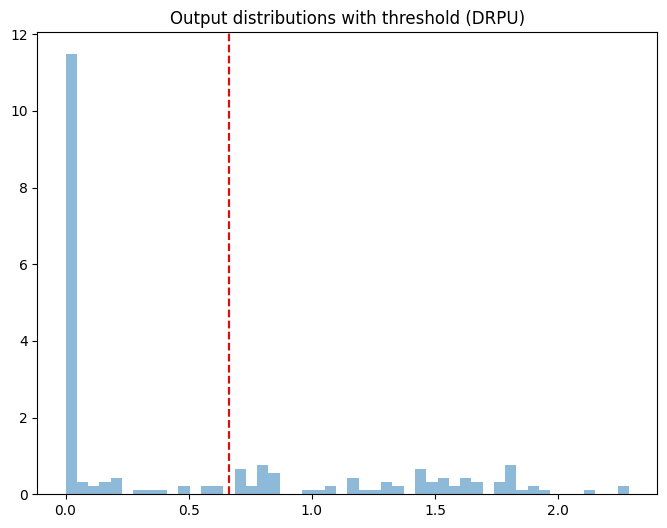

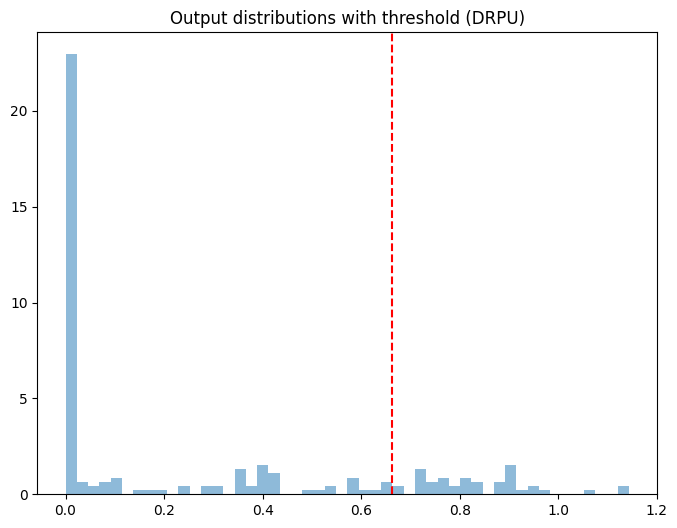

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 87.0000 - pos_fraction: 0.4800

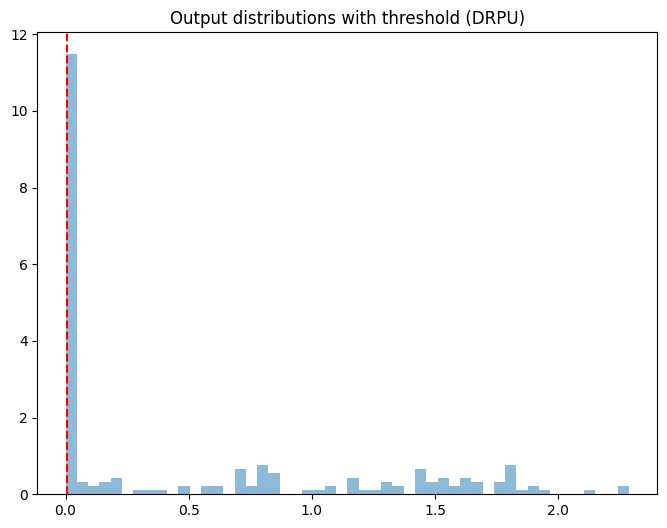

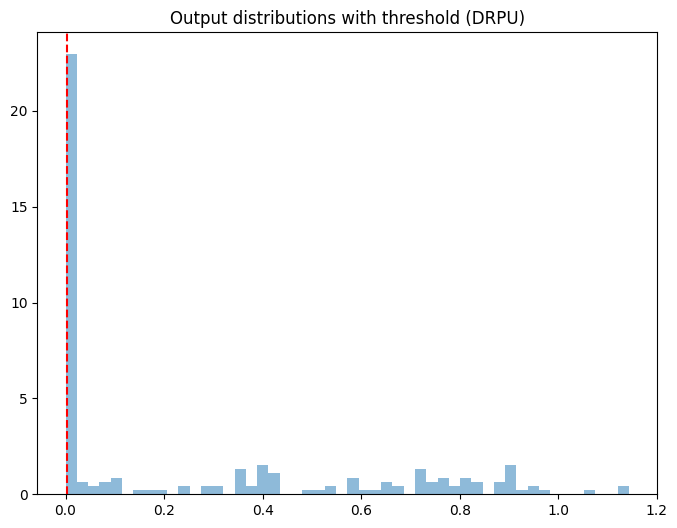

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1667 - accuracy: 88.5000 - pos_fraction: 0.4550

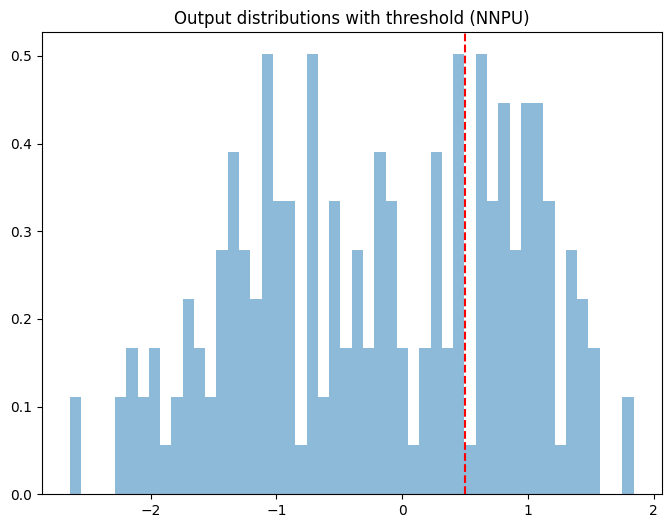

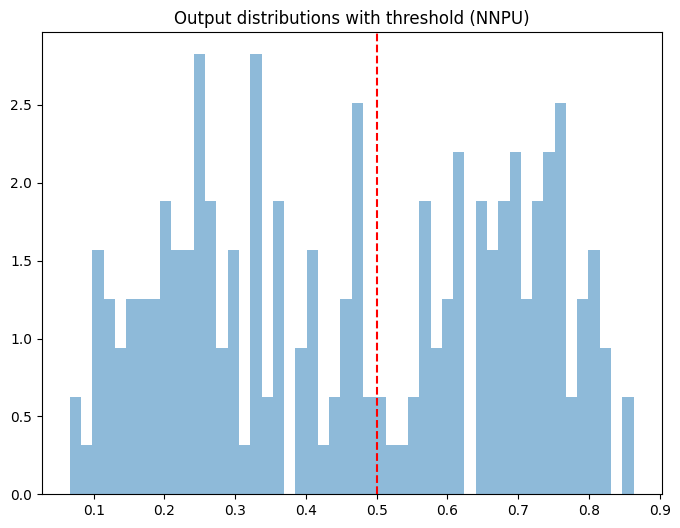

Epoch: 1/1
positive: torch.Size([80]), unlabeled: torch.Size([48]), alpha: 0.5
E_pp: 0.2356804609298706, E_pn: 0.9071078300476074, E_u: 0.018570316955447197, E_n: -0.43498361110687256, loss: 0.43498361110687256
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.024298466742038727, E_n: 0.024298466742038727, loss: -0.47570154070854187
1/3 [=>......] - ETA: 0s - test_loss: -0.0204 - accuracy: 86.5000 - pos_fraction: 0.2650

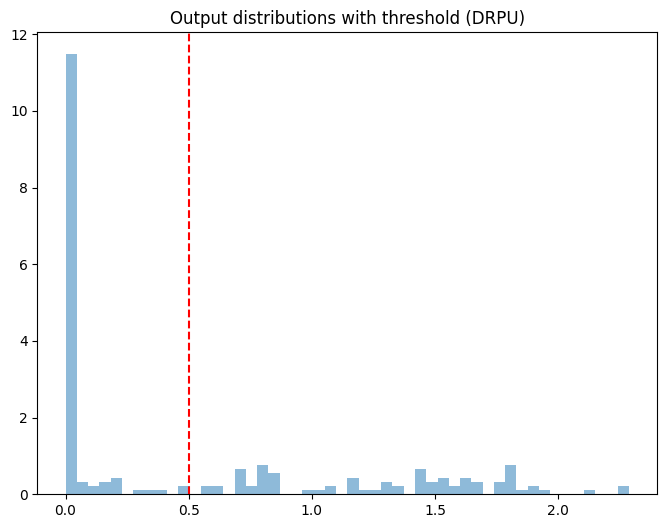

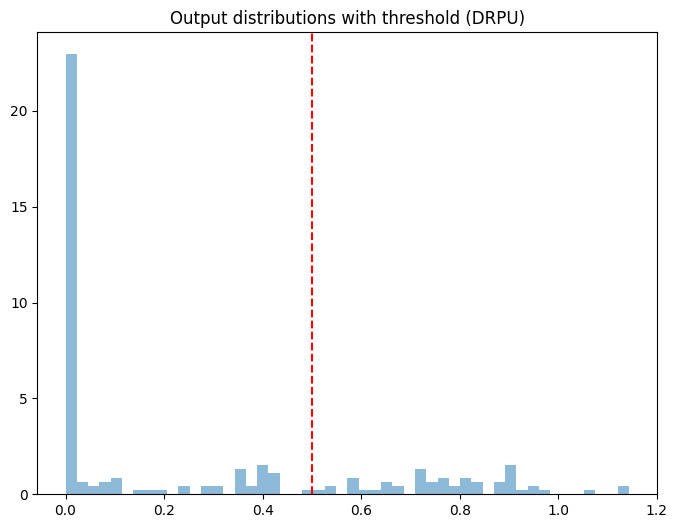

Metrics saved to output\ChestXRay/2475/0.5/0.4\nnPUcc\0.2\0\metrics.json
{'dataset_stats': {'train': {'n_pos': 1100, 'n_neg': 1100, 'n_p': 275, 'n_u': 2200, 'n_samples': 2475}, 'test': {'n_pos': 80, 'n_neg': 120, 'n_p': 0, 'n_u': 200, 'n_samples': 200}}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='ChestXRay/2475/0.5/0.4', label_frequency=0.2, exp_number=0, accuracy=0.885, precision=0.8131868131868132, recall=0.925, f1=0.8654970760233918, auc=0.8916666666666667, loss=None, epoch=None, stopping_epoch=None, time=None), 'roc_curve': {'fpr': [0.0, 0.0, 0.0, 0.008333333333333333, 0.008333333333333333, 0.016666666666666666, 0.016666666666666666, 0.03333333333333333, 0.03333333333333333, 0.041666666666666664, 0.041666666666666664, 0.05, 0.05, 0.06666666666666667, 0.06666666666666667, 0.075, 0.075, 0.09166666666666666, 0.09166666666666666, 0.1, 0.1, 0.125, 0.125, 0.13333333333333333, 0.13333333333333333, 0.14166666666666666, 0.14166666666666666, 0.16666666666666666, 0.1666666

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train set prior: 0.5
Epoch: 1/50
6/6 [========] - 0s 55ms/step - loss: 0.4831 - acc: 0.5536 - test_loss: 0.4958 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
2/6 [=>......] - ETA: 0s - loss: 0.4135 - acc: 0.6787

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [========] - 0s 62ms/step - loss: 0.3864 - acc: 0.7125 - test_loss: 0.4932 - test_accuracy: 43.5000 - pos_fraction: 0.0350
Epoch: 3/50
6/6 [========] - 0s 66ms/step - loss: 0.3203 - acc: 0.7994 - test_loss: 0.4856 - test_accuracy: 59.0000 - pos_fraction: 0.2100
Epoch: 4/50
6/6 [========] - 0s 66ms/step - loss: 0.2651 - acc: 0.8342 - test_loss: 0.4694 - test_accuracy: 69.0000 - pos_fraction: 0.3300
Epoch: 5/50
6/6 [========] - 0s 67ms/step - loss: 0.2240 - acc: 0.8537 - test_loss: 0.4419 - test_accuracy: 74.5000 - pos_fraction: 0.4250
Epoch: 6/50
6/6 [========] - 0s 69ms/step - loss: 0.1893 - acc: 0.8621 - test_loss: 0.4087 - test_accuracy: 79.0000 - pos_fraction: 0.4700
Epoch: 7/50
6/6 [========] - 0s 63ms/step - loss: 0.1591 - acc: 0.8674 - test_loss: 0.3746 - test_accuracy: 82.0000 - pos_fraction: 0.5000
Epoch: 8/50
6/6 [========] - 0s 53ms/step - loss: 0.1315 - acc: 0.8617 - test_loss: 0.3438 - test_accuracy: 85.5000 - pos_fraction: 0.5450
Epoch: 9/50
6/6 [========] - 0s 58ms/st

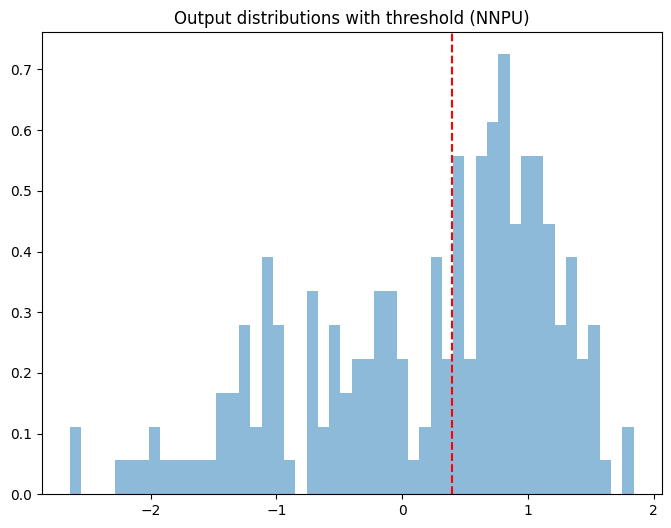

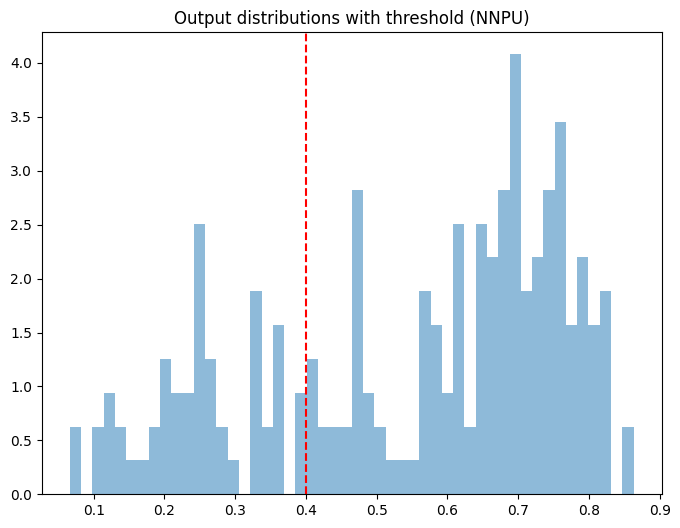

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.2040 - accuracy: 40.0000 - pos_fraction: 0.0000e+00

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


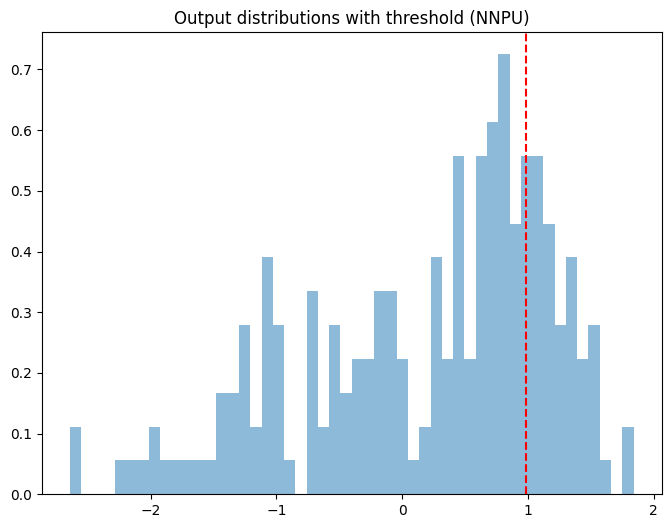

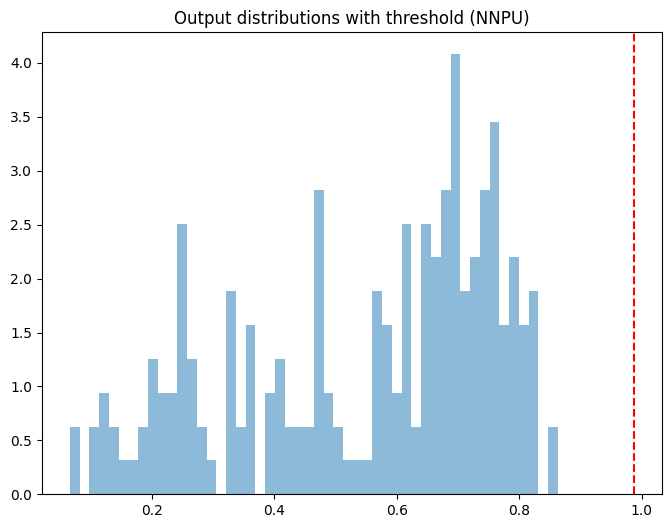

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.2040 - accuracy: 73.5000 - pos_fraction: 0.3550

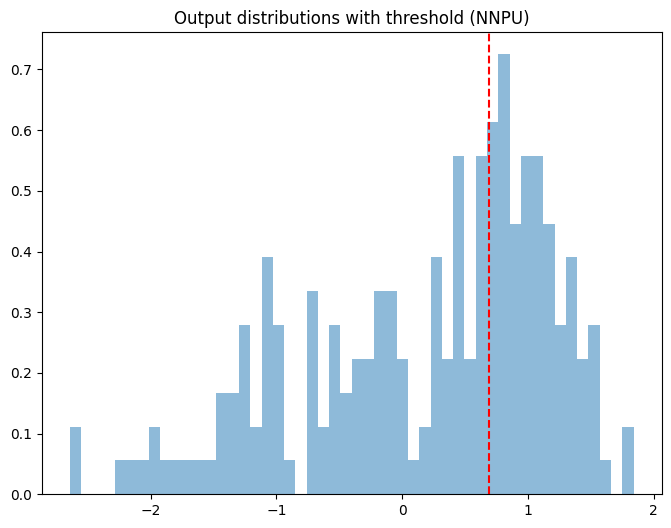

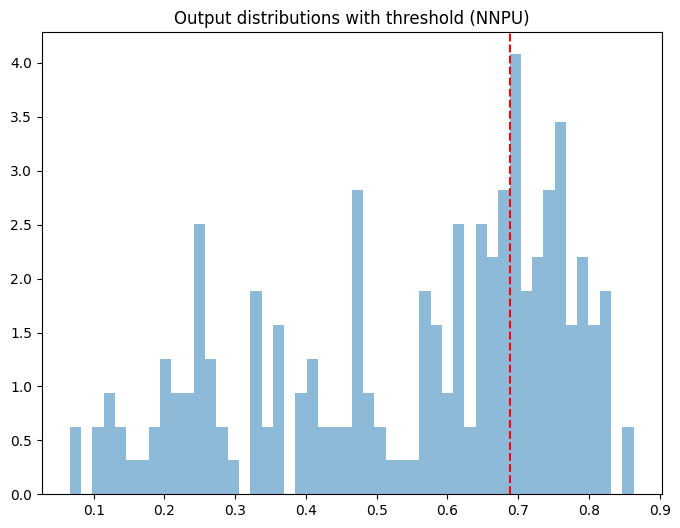

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.2040 - accuracy: 66.5000 - pos_fraction: 0.2750

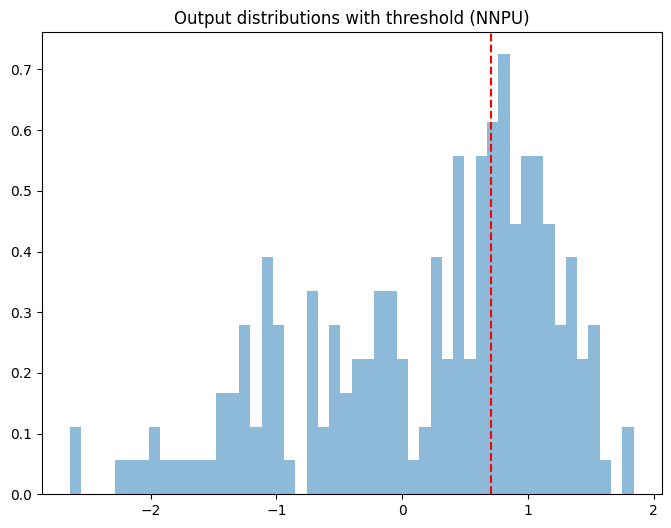

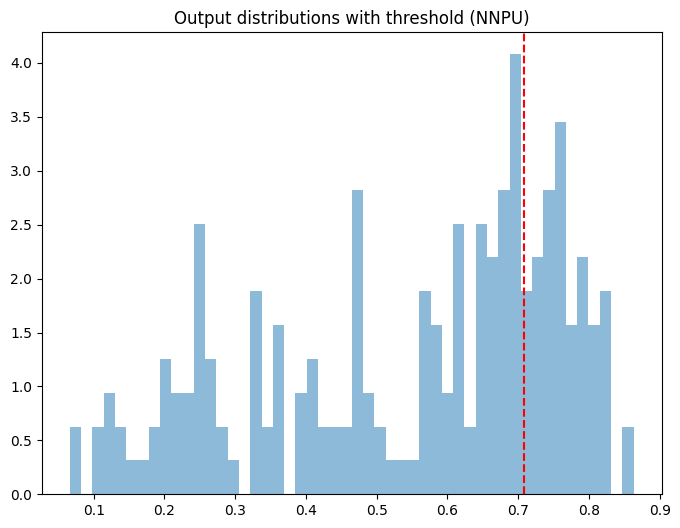

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.2040 - accuracy: 75.0000 - pos_fraction: 0.8400

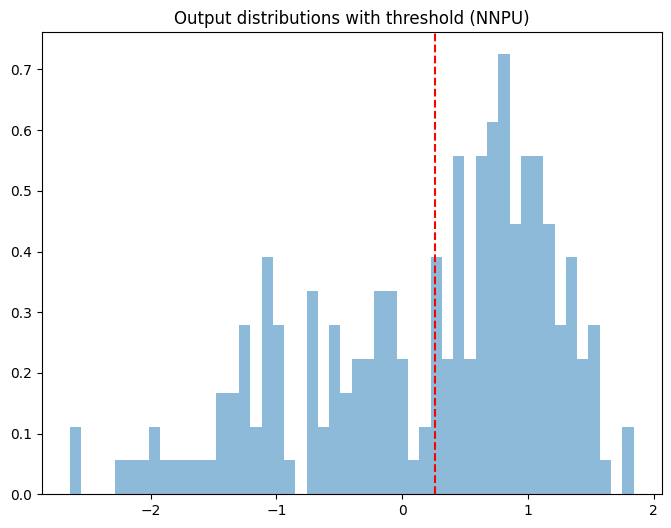

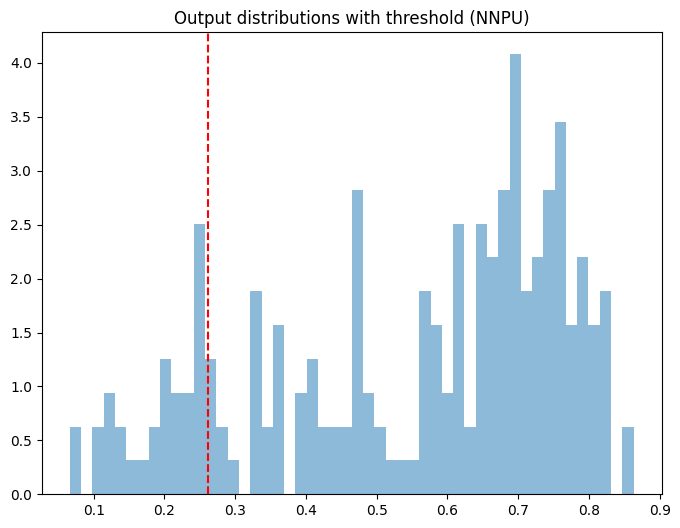

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.2040 - accuracy: 60.0000 - pos_fraction: 1.0000

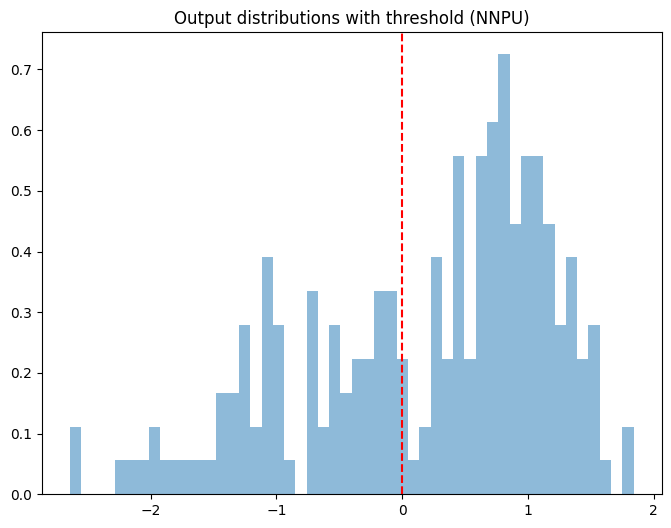

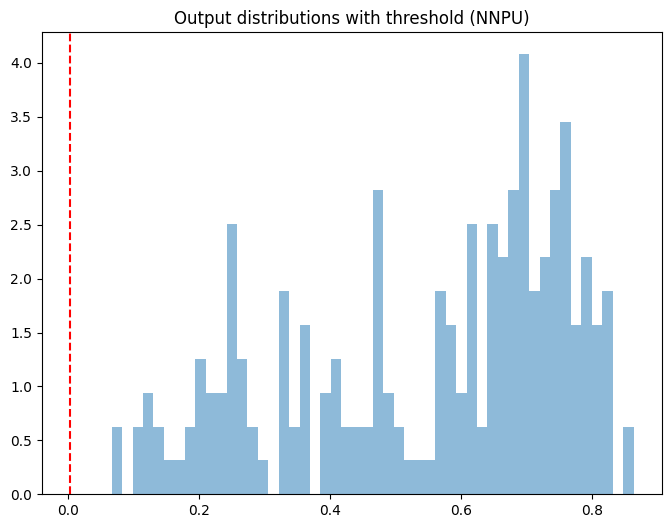

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 79.0000 - pos_fraction: 0.3900drpu y_scores:
[0.3044537  0.5743879  0.41205162 0.8127529  0.9150071  0.7897255
 0.9148346  0.3614985  0.97853255 0.9048881  0.         0.9116571
 0.87757534 0.83689296 0.7220291  0.81889194 0.61188793 0.9050788
 0.92543983 0.8151113  0.53700054 0.         1.0565503  0.24239099
 0.8243327  0.1140693  0.36374536 0.7465159  0.7139298  0.58000404
 0.35668918 0.82643056 0.6407739  0.75237465 0.8856931  0.9525886
 0.7255871  0.39936432 0.40839592 0.3902456  0.         0.89069235
 0.4189497  0.4039621  0.7630092  0.35194245 0.76330507 0.726

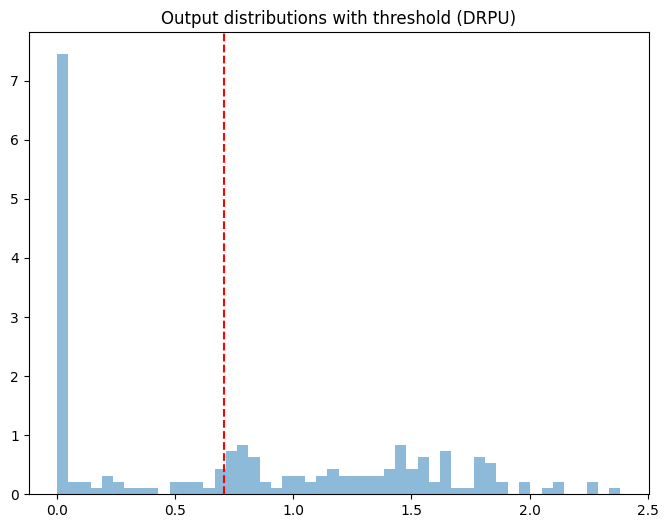

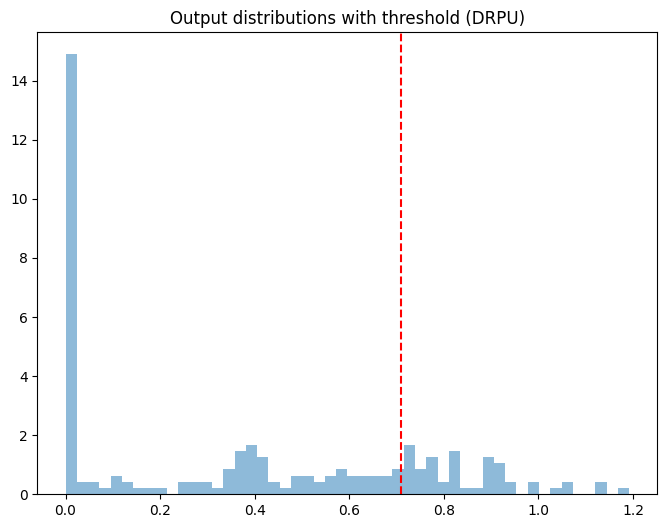

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 43.5000 - pos_fraction: 0.0350

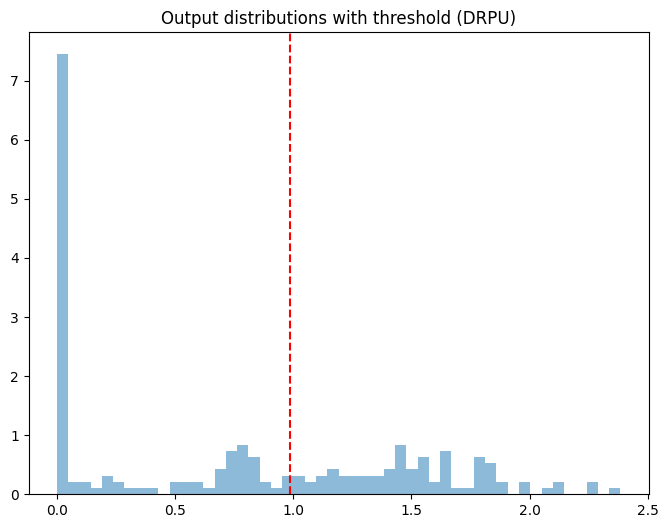

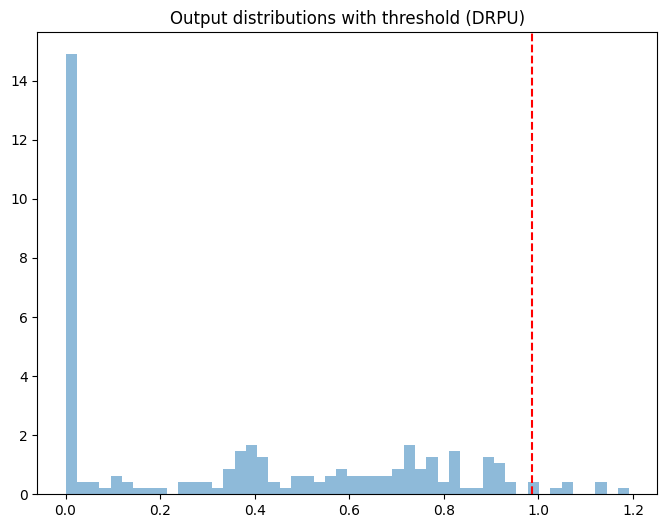

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 67.0000 - pos_fraction: 0.2700

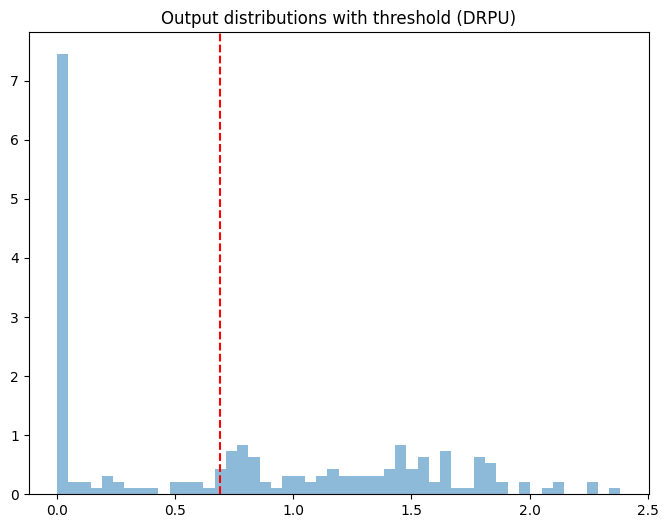

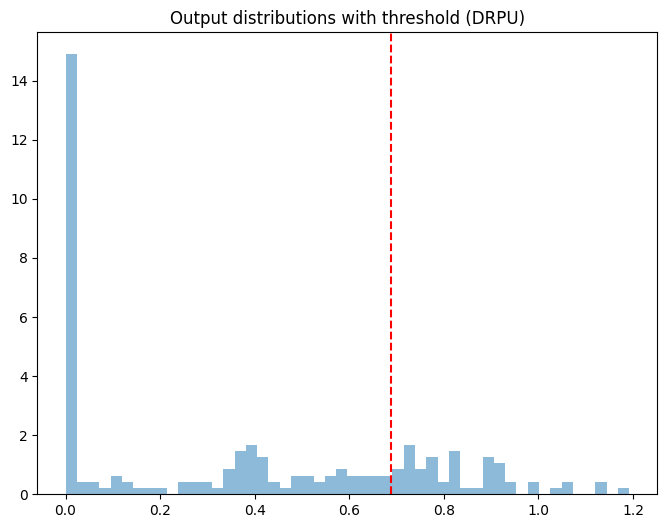

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 66.5000 - pos_fraction: 0.2650

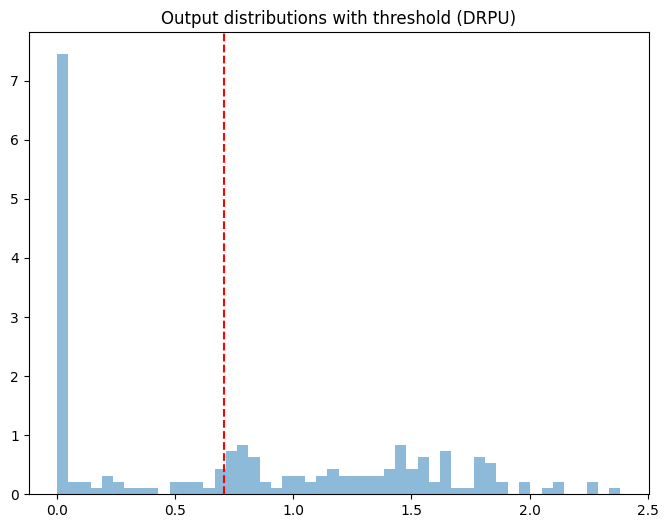

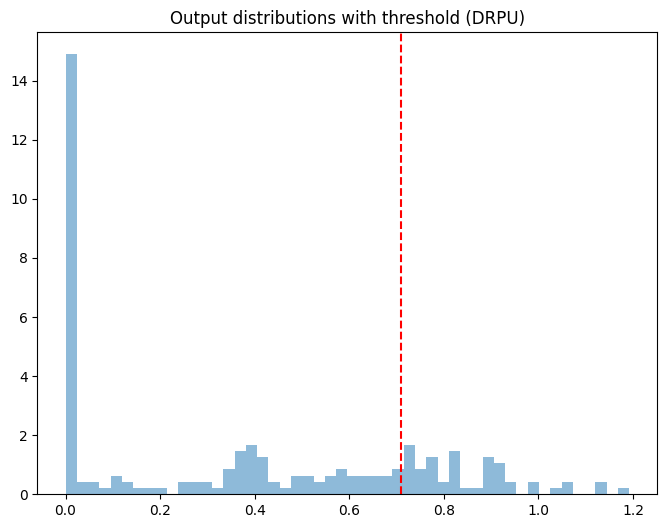

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 89.0000 - pos_fraction: 0.5700

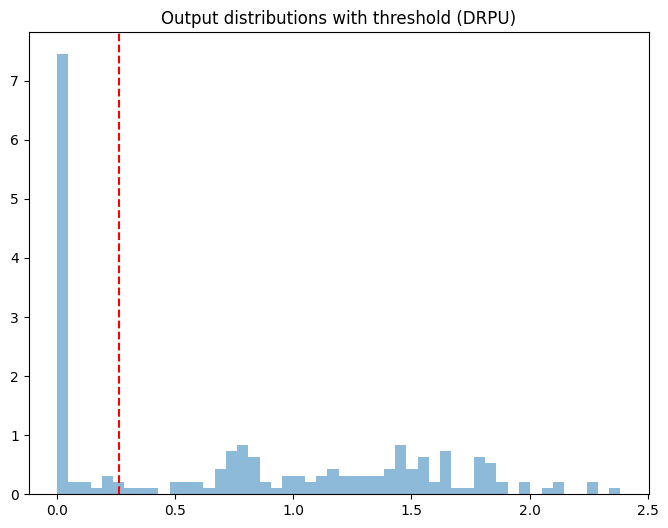

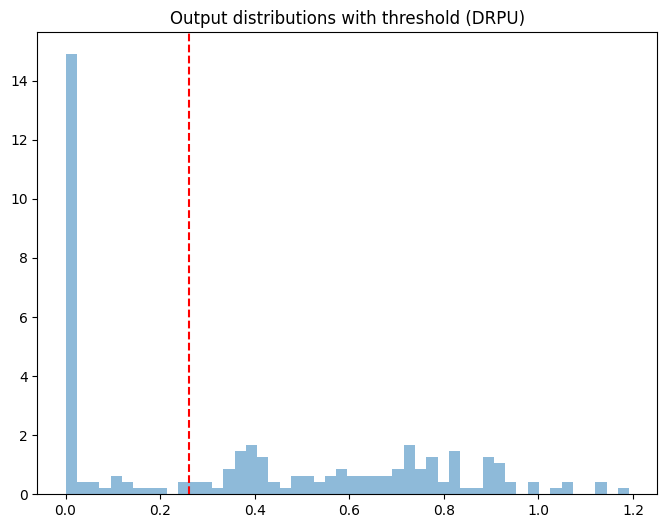

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 89.0000 - pos_fraction: 0.6500

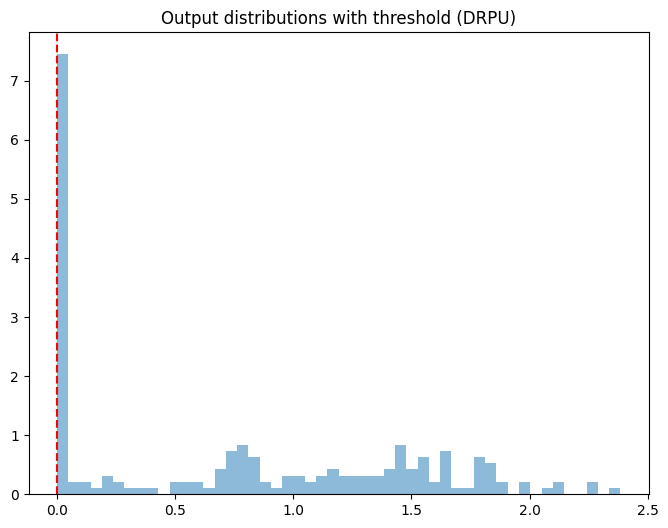

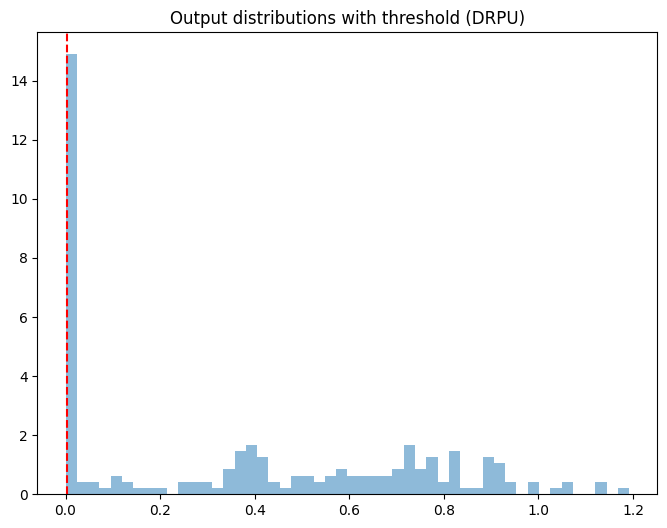

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.2040 - accuracy: 89.0000 - pos_fraction: 0.6200

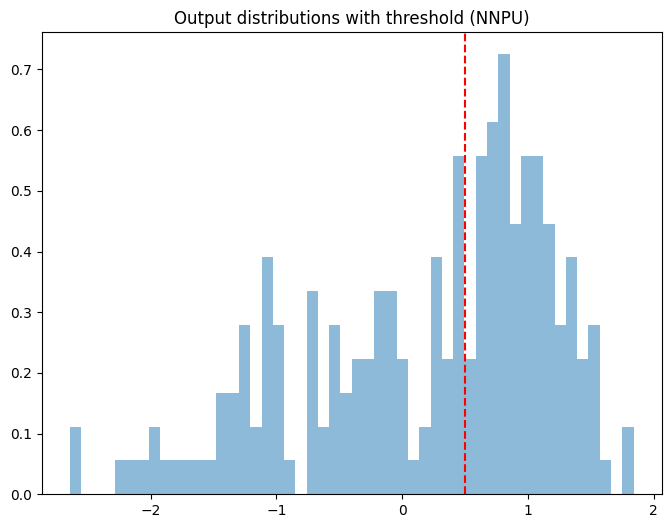

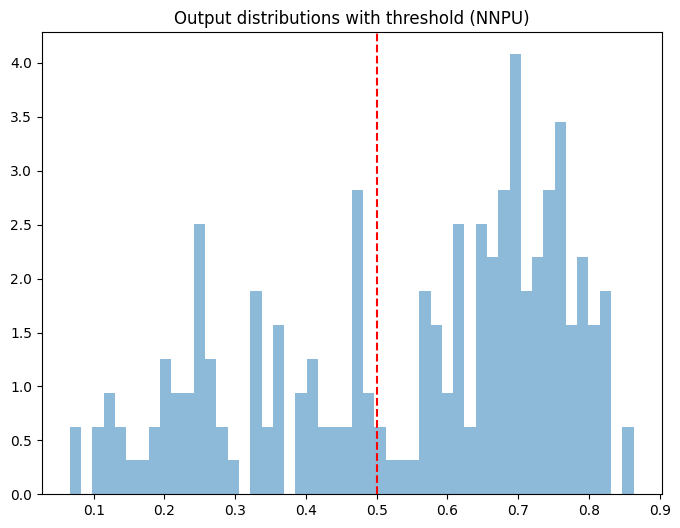

Epoch: 1/1
positive: torch.Size([120]), unlabeled: torch.Size([8]), alpha: 0.5
E_pp: 0.23861221969127655, E_pn: 0.8777629733085632, E_u: 0.006822772324085236, E_n: -0.432058721780777, loss: 0.432058721780777
positive: torch.Size([0]), unlabeled: torch.Size([72]), alpha: 0.5
E_pp: 0, E_pn: 0, E_u: 0.03531154617667198, E_n: 0.03531154617667198, loss: -0.4646884500980377
1/3 [=>......] - ETA: 0s - test_loss: -0.0163 - accuracy: 79.0000 - pos_fraction: 0.3900

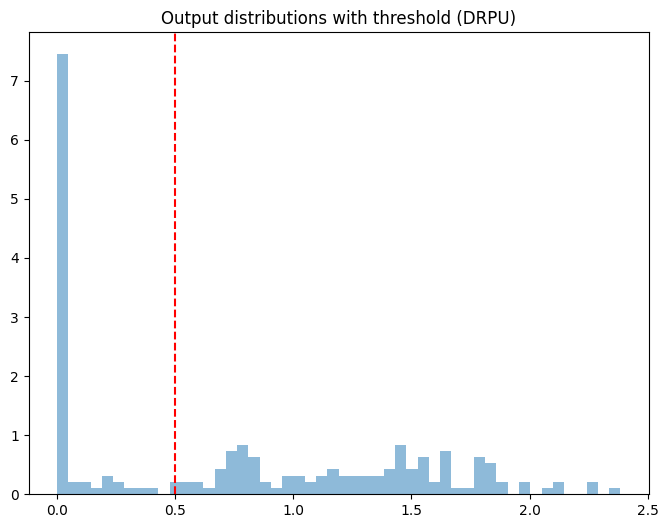

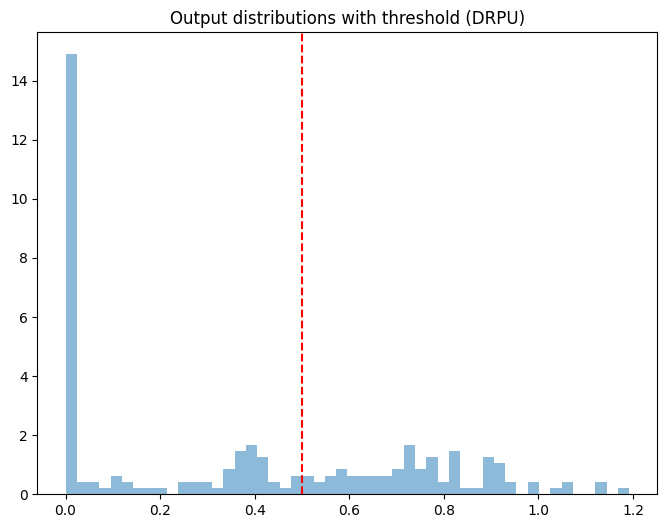

Metrics saved to output\ChestXRay/2475/0.5/0.6\nnPUcc\0.2\0\metrics.json
{'dataset_stats': {'train': {'n_pos': 1100, 'n_neg': 1100, 'n_p': 275, 'n_u': 2200, 'n_samples': 2475}, 'test': {'n_pos': 120, 'n_neg': 80, 'n_p': 0, 'n_u': 200, 'n_samples': 200}}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='ChestXRay/2475/0.5/0.6', label_frequency=0.2, exp_number=0, accuracy=0.89, precision=0.8951612903225806, recall=0.925, f1=0.9098360655737704, auc=0.8812500000000001, loss=None, epoch=None, stopping_epoch=None, time=None), 'roc_curve': {'fpr': [0.0, 0.0, 0.0, 0.0125, 0.0125, 0.025, 0.025, 0.05, 0.05, 0.0625, 0.0625, 0.075, 0.075, 0.0875, 0.0875, 0.1, 0.1, 0.1125, 0.1125, 0.125, 0.125, 0.15, 0.15, 0.1625, 0.1625, 0.175, 0.175, 0.2, 0.2, 0.2375, 0.2375, 0.25, 0.25, 0.2625, 0.2625, 0.275, 0.275, 0.6375, 0.6375, 1.0], 'tpr': [0.0, 0.008333333333333333, 0.43333333333333335, 0.43333333333333335, 0.5083333333333333, 0.5083333333333333, 0.575, 0.575, 0.7083333333333334, 0.7083333333

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train set prior: 0.5
Epoch: 1/50
6/6 [========] - 0s 70ms/step - loss: 0.4831 - acc: 0.5536 - test_loss: 0.3730 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
2/6 [=>......] - ETA: 0s - loss: 0.4135 - acc: 0.6787

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [========] - 0s 63ms/step - loss: 0.3864 - acc: 0.7125 - test_loss: 0.3719 - test_accuracy: 24.0000 - pos_fraction: 0.0400
Epoch: 3/50
6/6 [========] - 0s 55ms/step - loss: 0.3203 - acc: 0.7994 - test_loss: 0.3684 - test_accuracy: 43.5000 - pos_fraction: 0.2450
Epoch: 4/50
6/6 [========] - 0s 55ms/step - loss: 0.2651 - acc: 0.8342 - test_loss: 0.3611 - test_accuracy: 58.5000 - pos_fraction: 0.4050
Epoch: 5/50
6/6 [========] - 0s 60ms/step - loss: 0.2240 - acc: 0.8537 - test_loss: 0.3476 - test_accuracy: 70.5000 - pos_fraction: 0.5350
Epoch: 6/50
6/6 [========] - 0s 57ms/step - loss: 0.1893 - acc: 0.8621 - test_loss: 0.3302 - test_accuracy: 77.0000 - pos_fraction: 0.6000
Epoch: 7/50
6/6 [========] - 0s 57ms/step - loss: 0.1591 - acc: 0.8674 - test_loss: 0.3123 - test_accuracy: 81.0000 - pos_fraction: 0.6400
Epoch: 8/50
6/6 [========] - 0s 65ms/step - loss: 0.1315 - acc: 0.8617 - test_loss: 0.2945 - test_accuracy: 85.0000 - pos_fraction: 0.6800
Epoch: 9/50
6/6 [========] - 0s 67ms/st

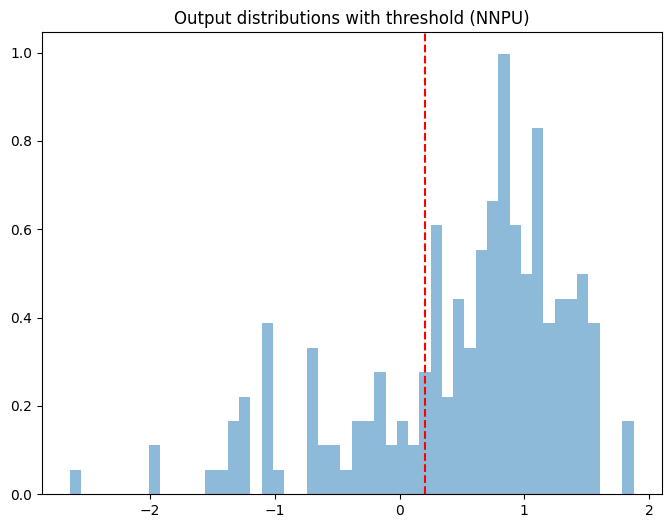

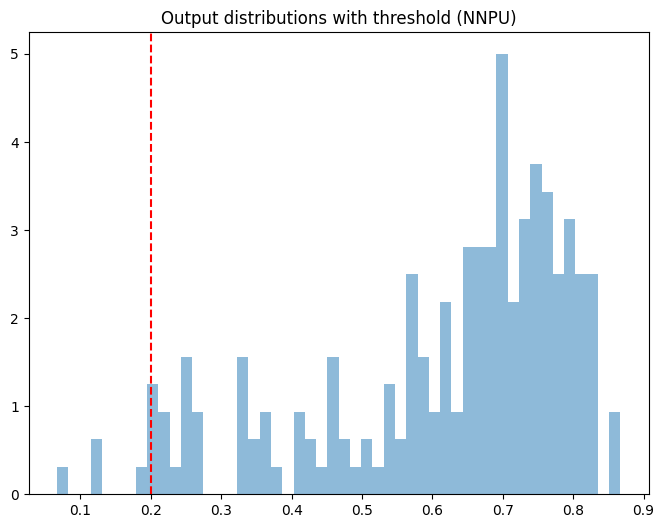

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1840 - accuracy: 20.0000 - pos_fraction: 0.0000e+00

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


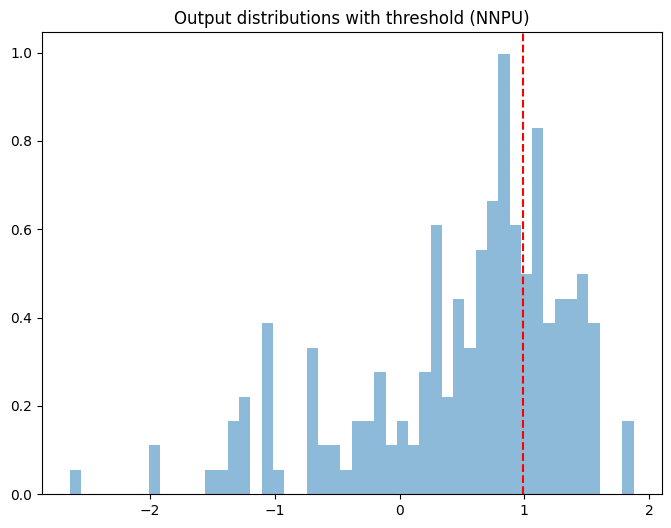

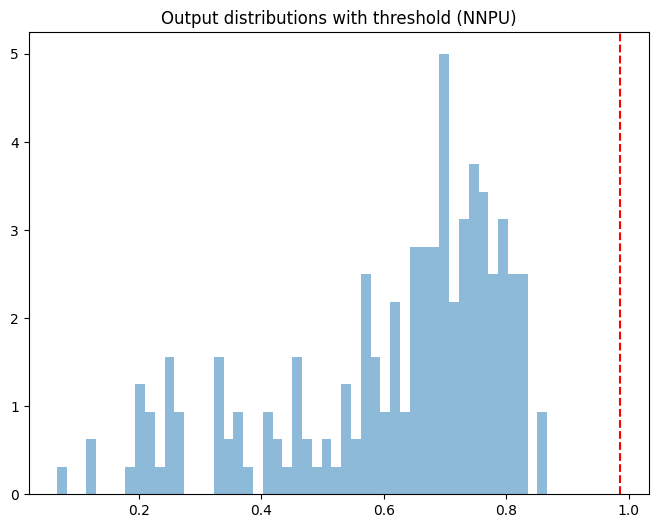

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1840 - accuracy: 21.5000 - pos_fraction: 0.0150

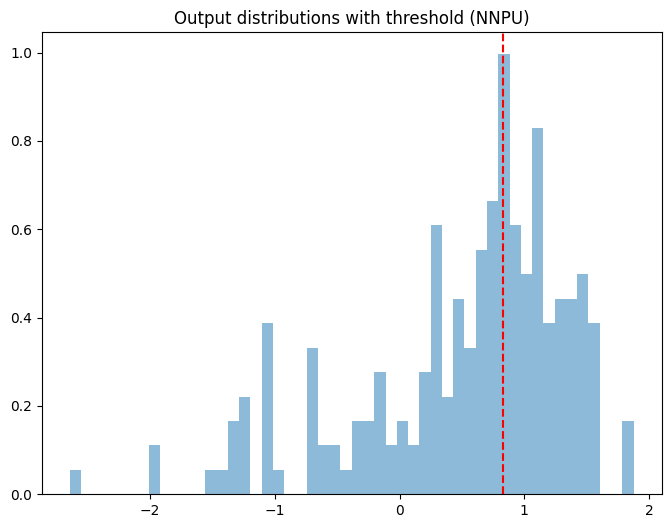

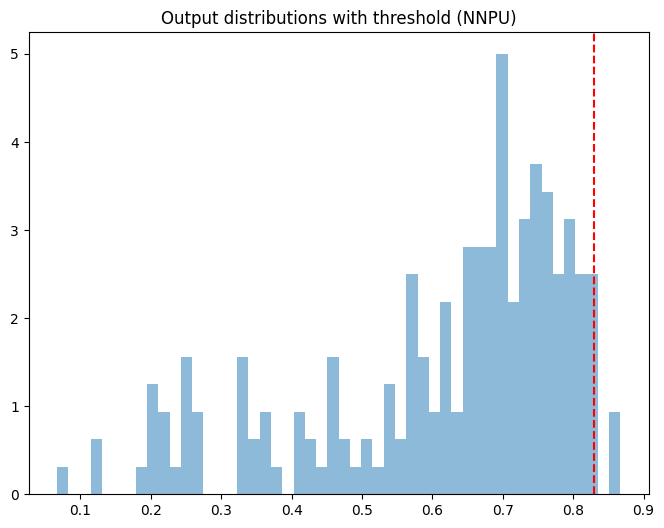

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1840 - accuracy: 83.0000 - pos_fraction: 0.6500

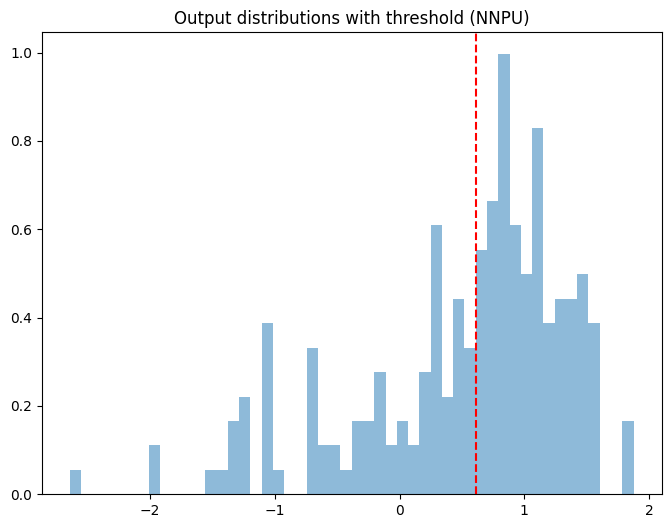

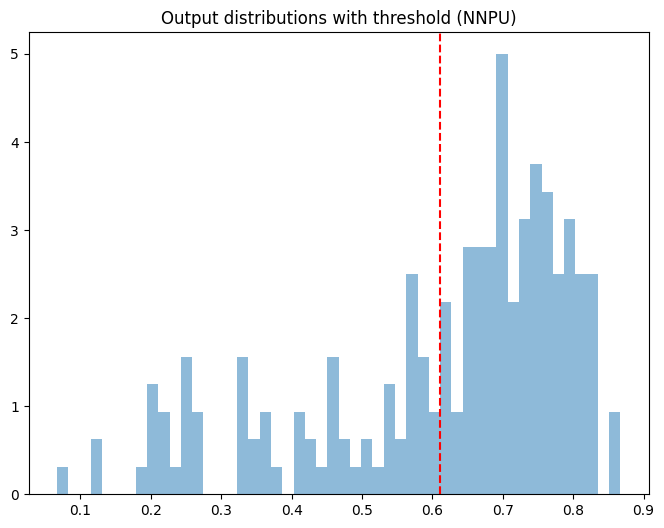

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1840 - accuracy: 80.0000 - pos_fraction: 1.0000

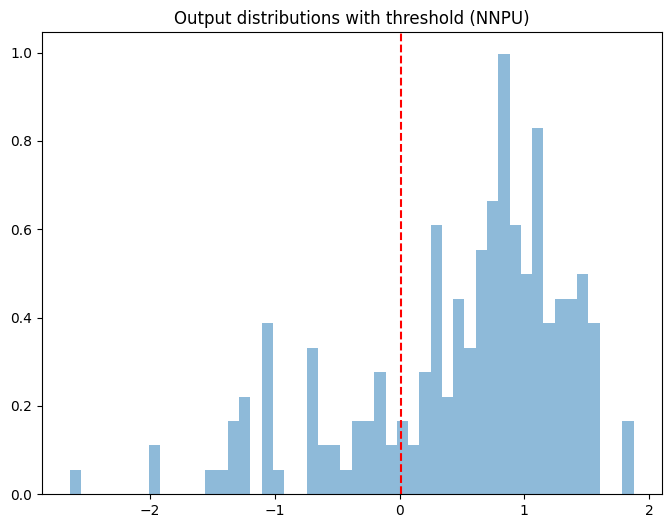

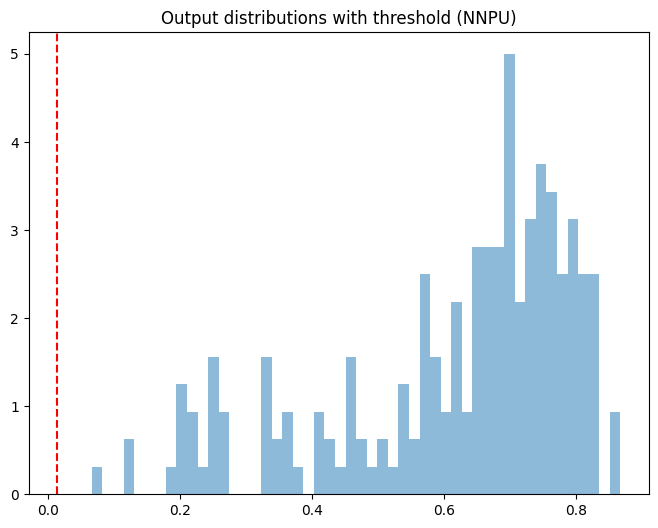

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1840 - accuracy: 80.0000 - pos_fraction: 1.0000

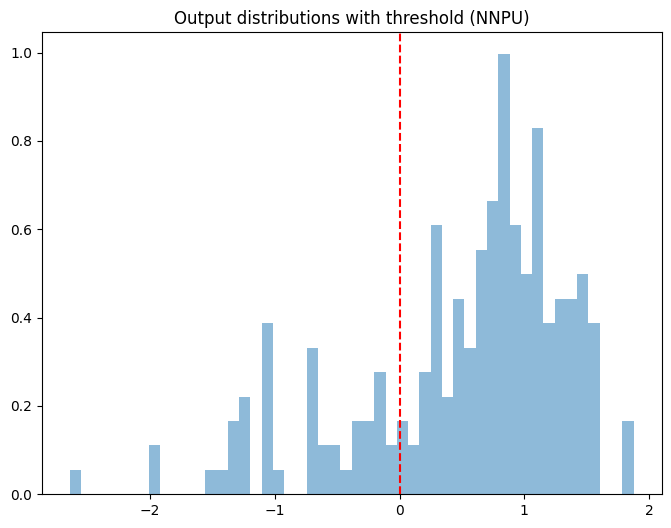

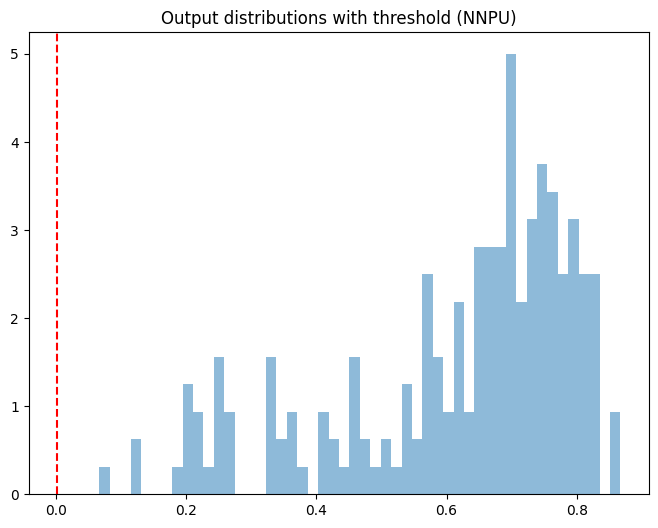

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 74.5000 - pos_fraction: 0.5450drpu y_scores:
[0.3044537  0.5743879  0.41205162 0.8127529  0.9150071  0.7897255
 0.9148346  0.3614985  0.97853255 0.9048881  0.         0.9116571
 0.87757534 0.83689296 0.7220291  0.81889194 0.61188793 0.9050788
 0.92543983 0.8151113  0.53700054 0.         1.0565503  0.24239099
 0.8243327  0.1140693  0.36374536 0.7465159  0.7139298  0.58000404
 0.35668918 0.82643056 0.6407739  0.75237465 0.8856931  0.9525886
 0.7255871  0.39936432 0.40839592 0.3902456  0.         0.89069235
 0.4189497  0.4039621  0.7630092  0.351942

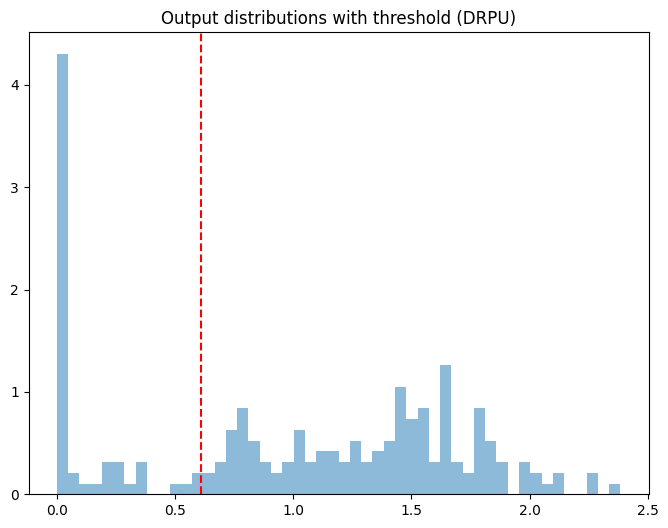

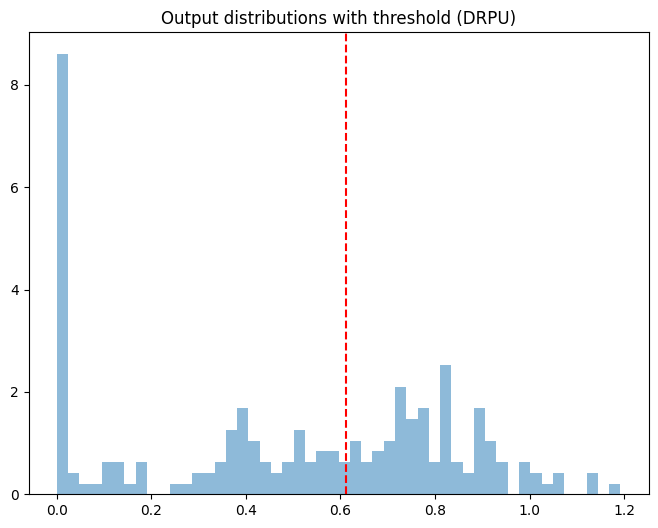

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 24.5000 - pos_fraction: 0.0450

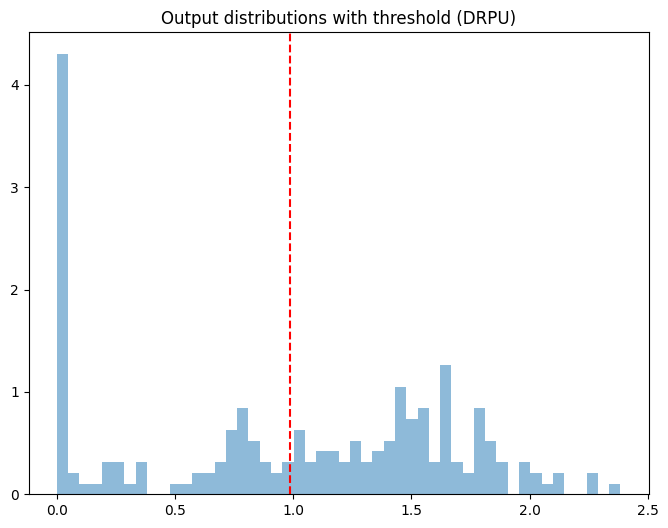

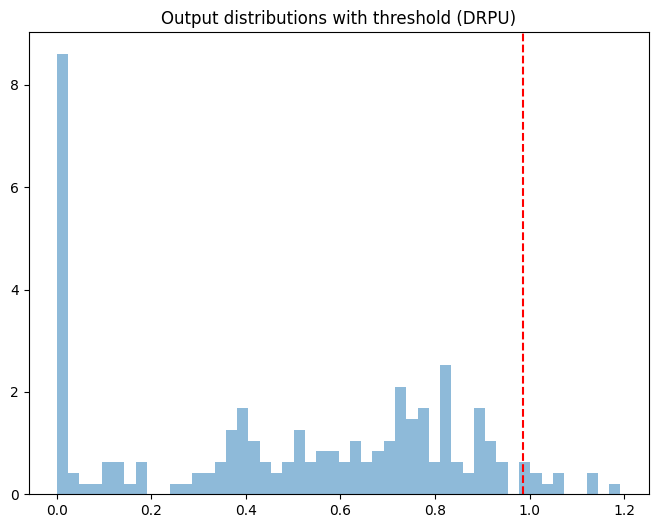

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 36.0000 - pos_fraction: 0.1600

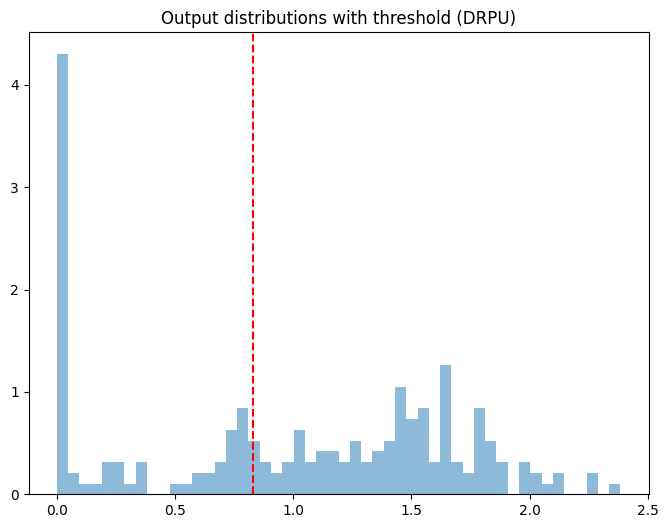

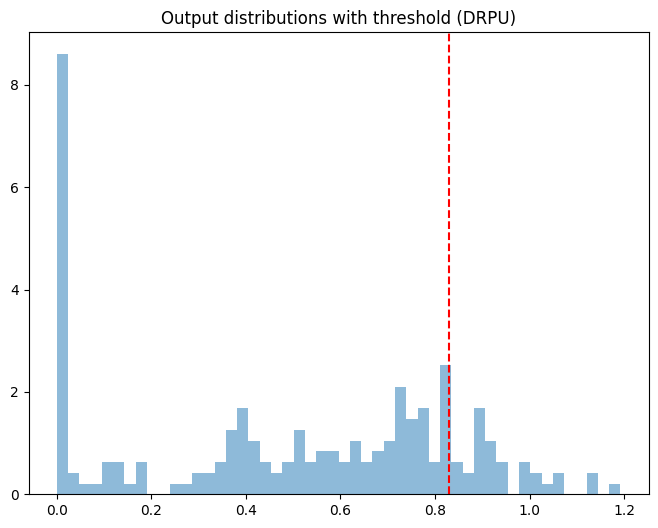

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 65.0000 - pos_fraction: 0.4500

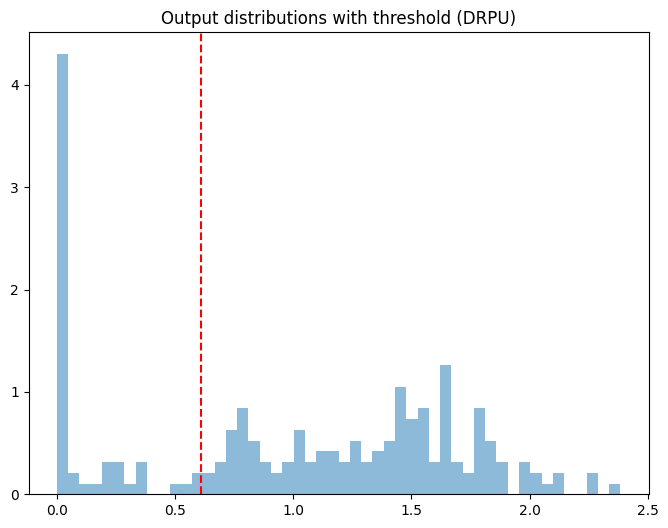

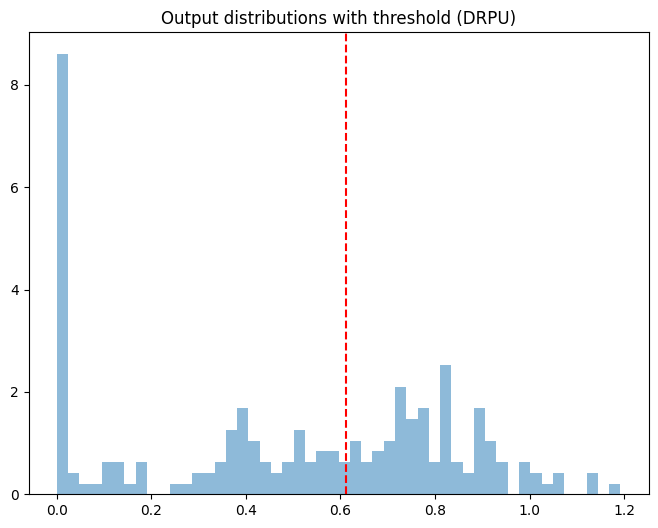

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 92.5000 - pos_fraction: 0.7950

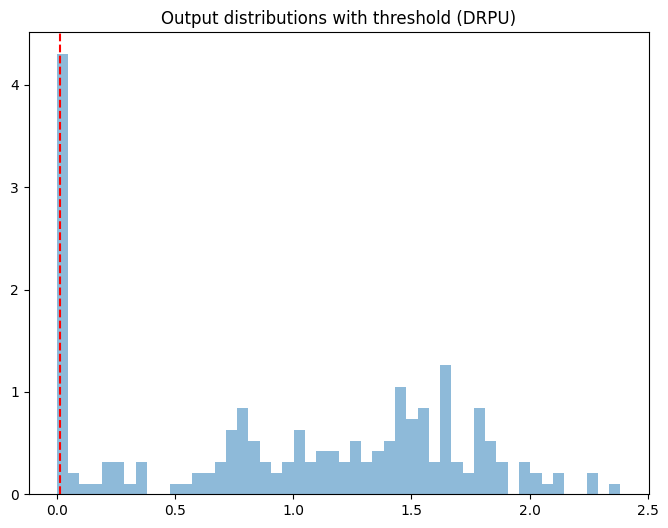

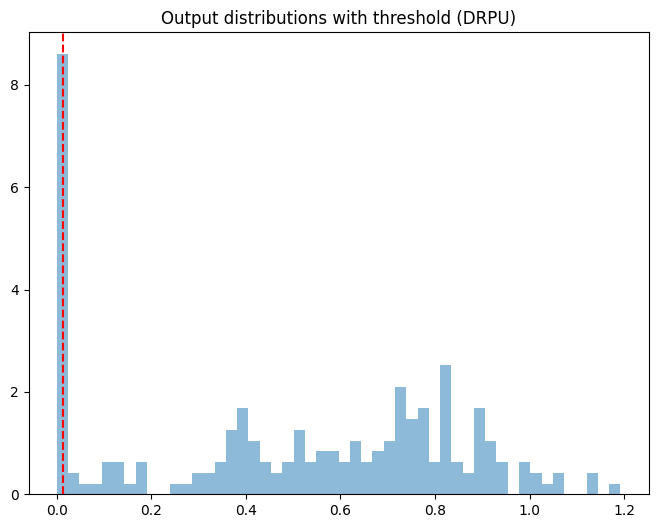

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 92.5000 - pos_fraction: 0.7950

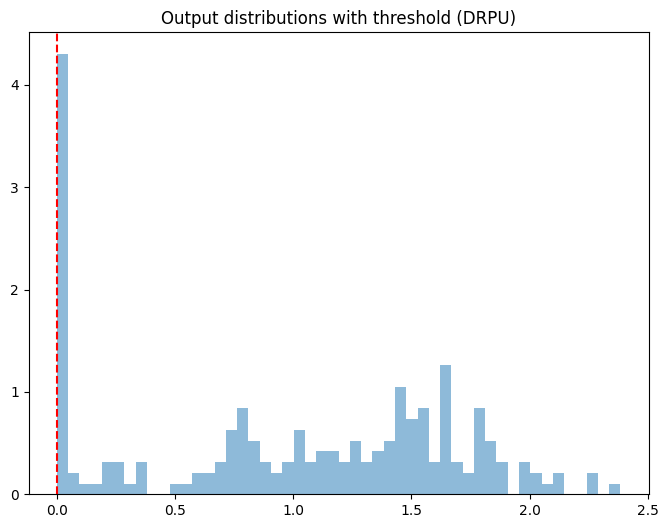

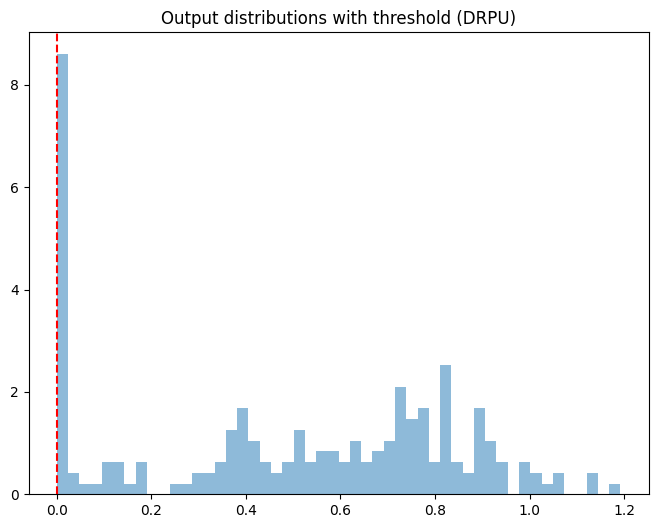

Epoch: 1/1
1/3 [=>......] - ETA: 0s - test_loss: 0.1840 - accuracy: 92.5000 - pos_fraction: 0.7750

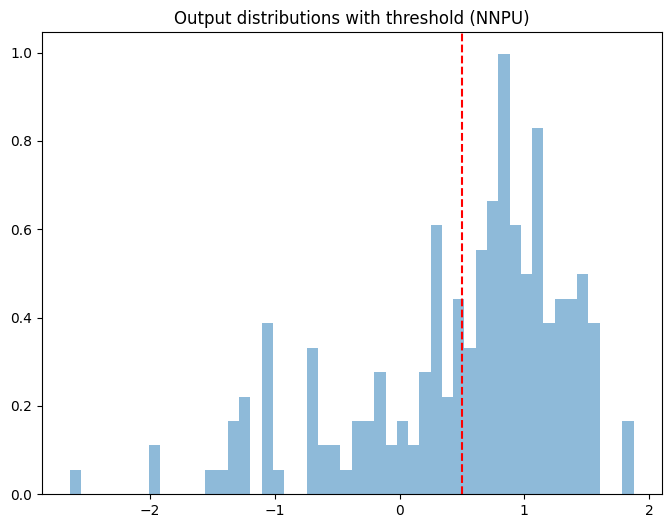

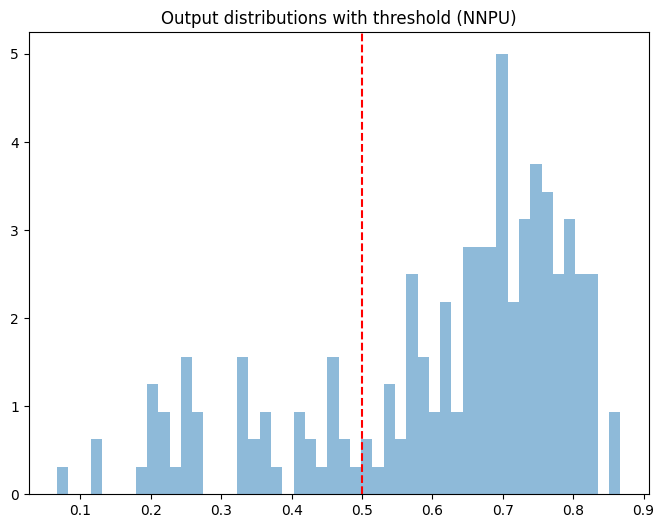

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.5
E_pp: 0.23817665874958038, E_pn: 0.8768516778945923, E_u: 0, E_n: -0.43842583894729614, loss: 0.43842583894729614
positive: torch.Size([32]), unlabeled: torch.Size([40]), alpha: 0.5
E_pp: 0.1832398772239685, E_pn: 1.0145540237426758, E_u: 0.022284379228949547, E_n: -0.4849926233291626, loss: 0.4849926233291626
1/3 [=>......] - ETA: 0s - test_loss: 0.4617 - accuracy: 74.5000 - pos_fraction: 0.5450

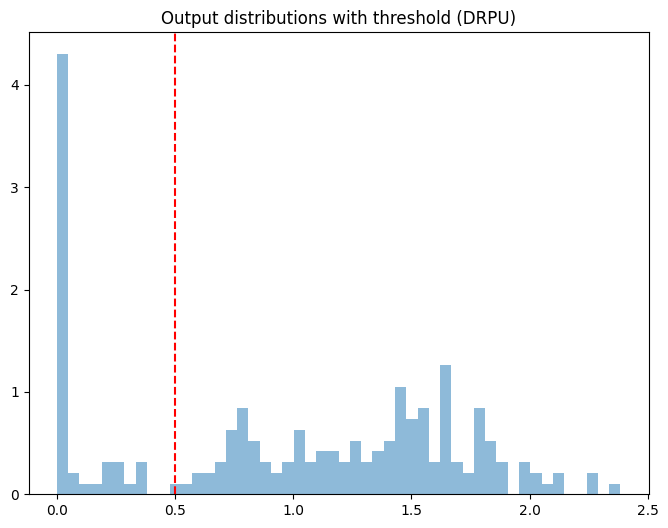

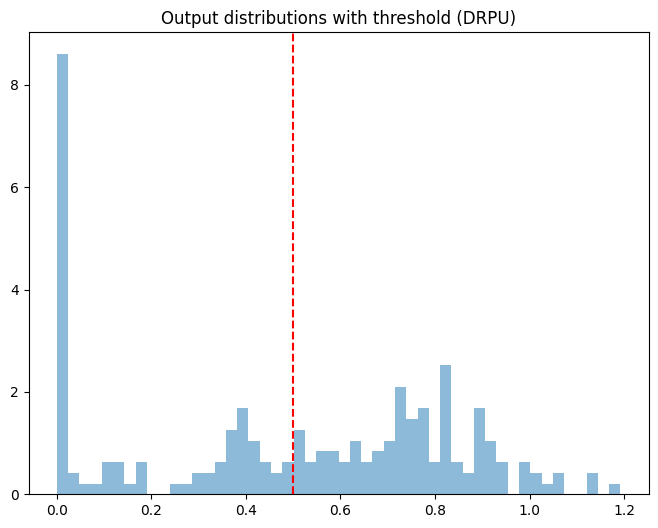

Metrics saved to output\ChestXRay/2475/0.5/0.8\nnPUcc\0.2\0\metrics.json
{'dataset_stats': {'train': {'n_pos': 1100, 'n_neg': 1100, 'n_p': 275, 'n_u': 2200, 'n_samples': 2475}, 'test': {'n_pos': 160, 'n_neg': 40, 'n_p': 0, 'n_u': 200, 'n_samples': 200}}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='ChestXRay/2475/0.5/0.8', label_frequency=0.2, exp_number=0, accuracy=0.925, precision=0.967741935483871, recall=0.9375, f1=0.9523809523809523, auc=0.90625, loss=None, epoch=None, stopping_epoch=None, time=None), 'roc_curve': {'fpr': [0.0, 0.0, 0.0, 0.025, 0.025, 0.05, 0.05, 0.075, 0.075, 0.125, 0.125, 0.15, 0.15, 0.175, 0.175, 0.2, 0.2, 0.5, 0.5, 0.625, 0.625, 1.0], 'tpr': [0.0, 0.00625, 0.44375, 0.44375, 0.525, 0.525, 0.85, 0.85, 0.86875, 0.86875, 0.95, 0.95, 0.96875, 0.96875, 0.98125, 0.98125, 0.9875, 0.9875, 0.99375, 0.99375, 1.0, 1.0], 'thresholds': [1.8670753240585327, 0.8670753240585327, 0.7207216024398804, 0.7143721580505371, 0.6969786882400513, 0.6964876651763916, 0

In [4]:
# ChestXRay
# train data
# 4077 observations (2973 positive, prior - 0.729)
# test data
# 582 observations (411 positive, prior - 0.706)

from PULS.models import LabelShiftConfig
from PULS.dataset import ChestXRay_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequency = 0.2
pi_grid = [0.2, 0.4, 0.6, 0.8]

for test_pi in pi_grid:
    label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=2475, test_prior=test_pi, test_n_samples=200)

    dataset_config = DatasetConfig(
        f"ChestXRay/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
        DatasetClass=ChestXRay_PULS,
        PULabelerClass=SCAR_CC_Labeler,
    )
    fashion_mnist_experiment_config = ExperimentConfig(
        PULoss=nnPUccLoss,
        dataset_config=dataset_config,
        label_frequency=label_frequency,
        exp_number=exp_number,
        force_cpu=True,
    )

    experiment = PULSExperiment(experiment_config=fashion_mnist_experiment_config, label_shift_config=label_shift_config)
    experiment.run()
    experiment.train_ratio_estimator()
    experiment.test_shifted()

    print(experiment.metrics)
    print(experiment.test_pis)

In [3]:
from PULS.dataset import ChestXRay_PULS
from nnPU.dataset import SCAR_CC_Labeler

data = ChestXRay_PULS(root='./data', train=True, download=True, pu_labeler=SCAR_CC_Labeler(label_frequency=0.1 ))

print(data.dataset_stats)
print(f'observations: {data.dataset_stats["n_samples"]}')
print(f'positives: {data.dataset_stats["n_pos"] + data.dataset_stats["n_p"]}')
print(f'prior: {(data.dataset_stats["n_pos"] + data.dataset_stats["n_p"]) / data.dataset_stats["n_samples"]}')

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'n_pos': 2675, 'n_neg': 1104, 'n_p': 298, 'n_u': 3779, 'n_samples': 4077}
observations: 4077
positives: 2973
prior: 0.7292126563649742


### all data

In [ ]:
# ChestXRay
# train data
# 4077 observations (2973 positive, prior - 0.729)
# test data
# 582 observations (411 positive, prior - 0.706)

from PULS.models import LabelShiftConfig
from PULS.dataset import ChestXRay_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequencies = [0.1, 0.25, 0.5, 0.75, 0.9]

for label_frequency in label_frequencies:
    label_shift_config = LabelShiftConfig()

    dataset_config = DatasetConfig(
        f"ChestXRay/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
        DatasetClass=ChestXRay_PULS,
        PULabelerClass=SCAR_CC_Labeler,
    )
    fashion_mnist_experiment_config = ExperimentConfig(
        PULoss=nnPUccLoss,
        dataset_config=dataset_config,
        label_frequency=label_frequency,
        exp_number=exp_number,
        force_cpu=True,
    )

    experiment = PULSExperiment(experiment_config=fashion_mnist_experiment_config, label_shift_config=label_shift_config)
    experiment.run()
    experiment.train_ratio_estimator()
    experiment.test_shifted()

    print(experiment.metrics)
    print(experiment.test_pis)

In [ ]:
# from matplotlib.text import TextPath
# import matplotlib.pyplot as plt

# results_df["avg_true_accuracy_diff"] = results_df["avg_true_pi_accuracy"] - results_df["avg_not_adjusted_accuracy"]

# sns.set(style="whitegrid")
# plt.figure(figsize=(12, 6))
# plt.title("Average accuracy difference between adjusted model with true pi and model without adjustment")
# sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_true_accuracy_diff"), annot=True, fmt=".2f", 
#     cmap= "PiYG",
#     vmin= min(results_df["avg_true_accuracy_diff"]),
#     vmax= max(results_df["avg_true_accuracy_diff"]),
#     center=0)

# for i, pi in enumerate(PI_LIST):
#     for j, pi_new in enumerate(PI_LIST):
#         plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
# for i, pi in enumerate(PI_LIST):
#     for j, pi_new in enumerate(PI_LIST):
#         plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

# true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with true pi")
# positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (in pred)\nnot adjusted - adjusted model")
# plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
# plt.show()